In [1]:
!pip install uproot3

%load_ext autoreload
%autoreload 2


from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import uproot3
import pandas

In [2]:
from matplotlib.colors import LogNorm

In [3]:
plt.rcParams.update({'font.size': 18})

In [4]:
import scipy.signal

In [5]:
from numpy.fft import fft, ifft, ifftshift

In [6]:
from matplotlib.colors import LogNorm

In [7]:
PATH = 'data/late_light/'
FNAME = 'prod_extbnb_optfilter_mcc9.0_reco2_lite_C2'
wffile = uproot3.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]

FileNotFoundError: [Errno 2] No such file or directory: 'data/late_light/prod_extunbiased_swizzle_crt_inclusive_v6_v6a_goodruns_mcc9_run3.root'

In [ ]:
wfdf = wffile.pandas.df(flatten=False)

In [ ]:
#TODO: Optmize the data loading process

print (wfdf.keys())
print (wfdf.shape)

In [ ]:
ctr = 0
for idx,row in wfdf.iterrows():
    if (idx%100 != 0): continue
    print (idx)
    fig = plt.figure(figsize=(15,6))
    for pmt in range(26,32):
        plt.plot(row['wf_%02i'%pmt] + (pmt-26)*10)
    plt.ylim([2000,2200])
    plt.show()
    ctr += 1
    if (ctr >= 10):
        break

0


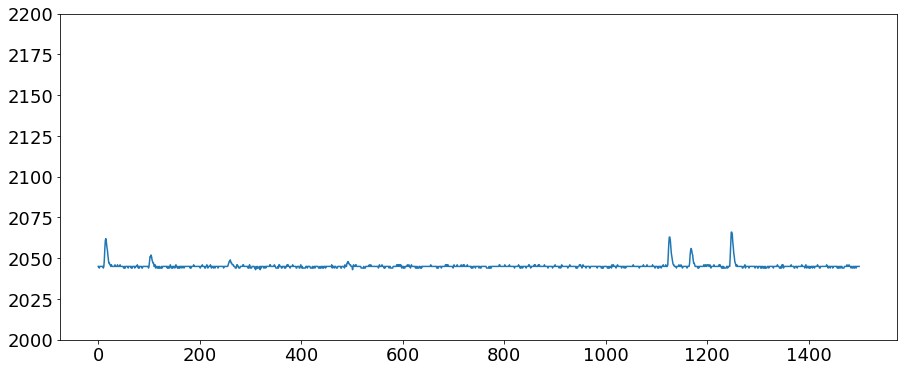

100


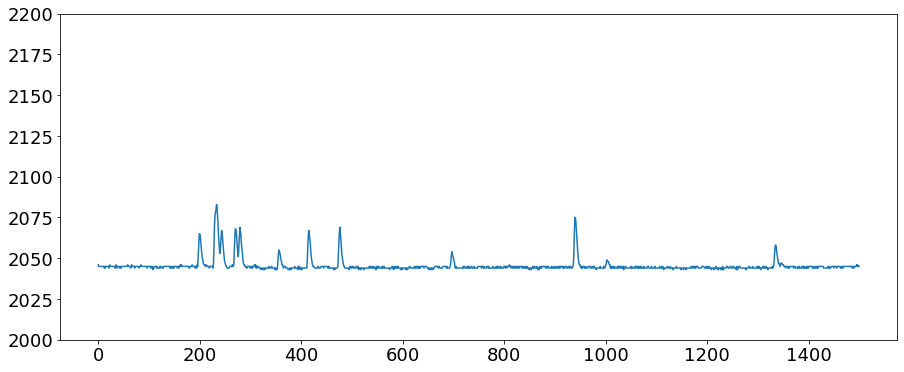

200


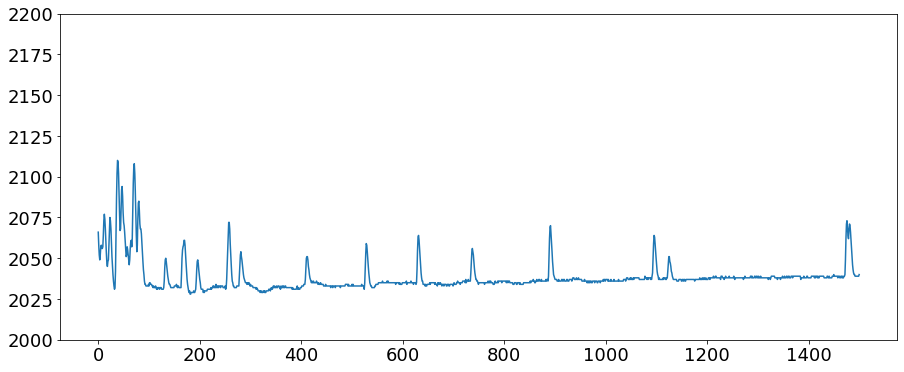

300


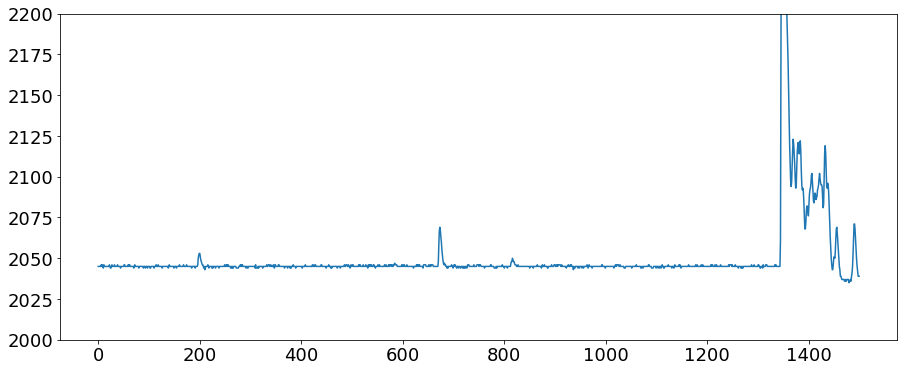

400


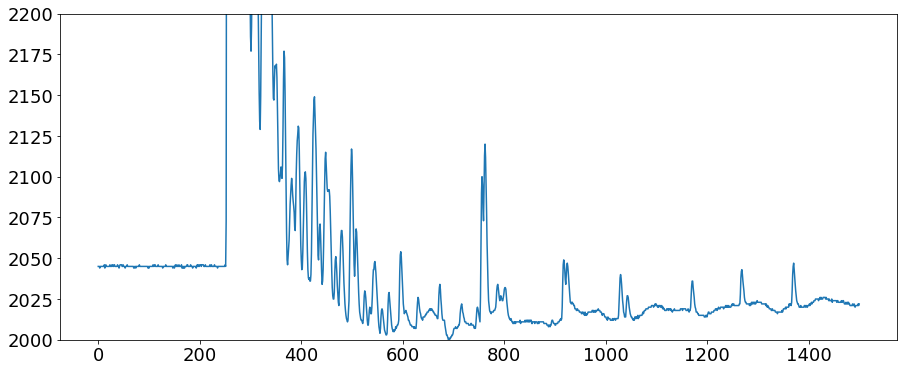

500


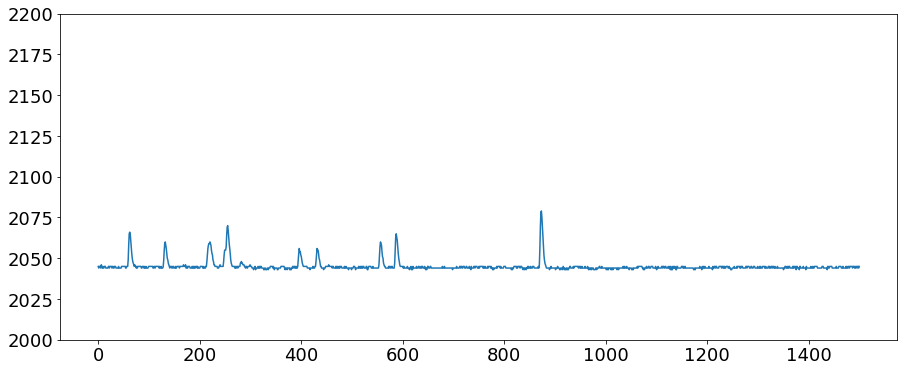

600


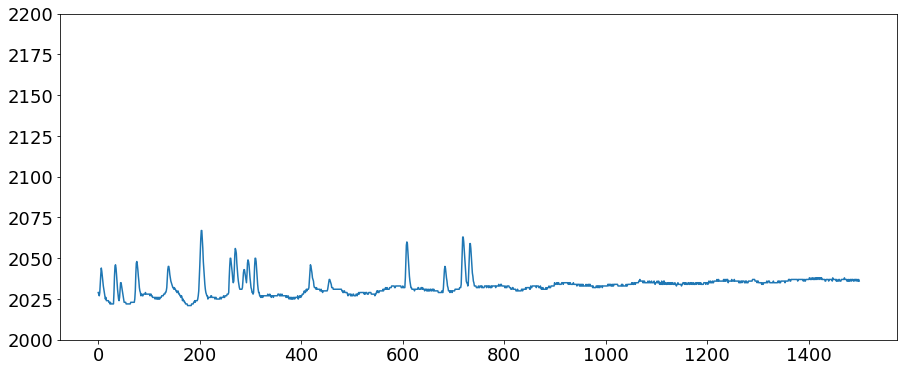

700


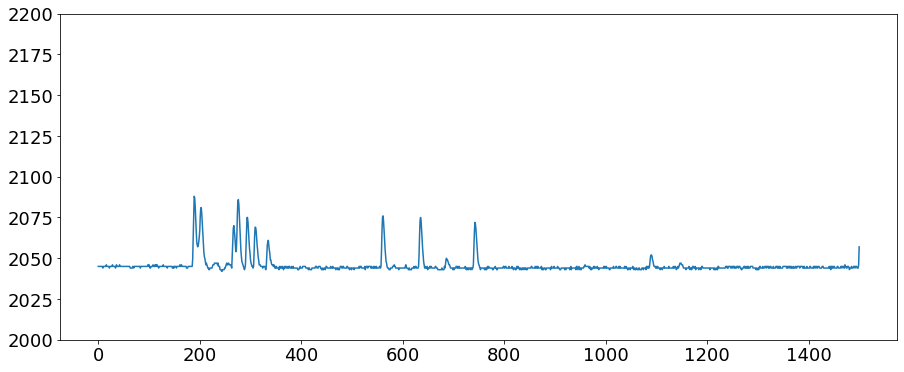

800


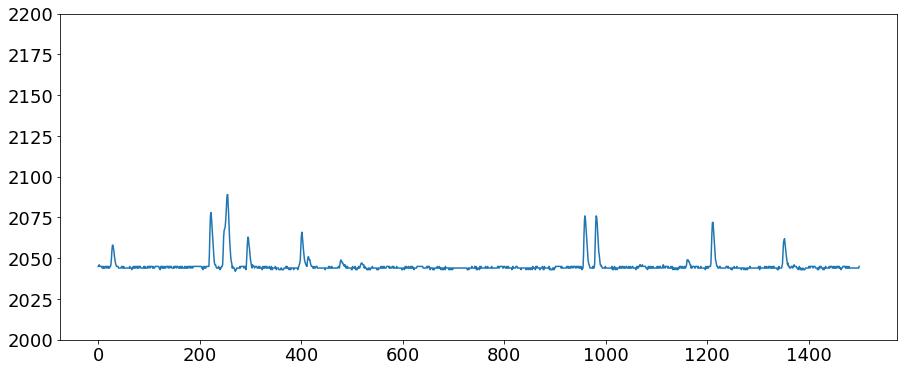

900


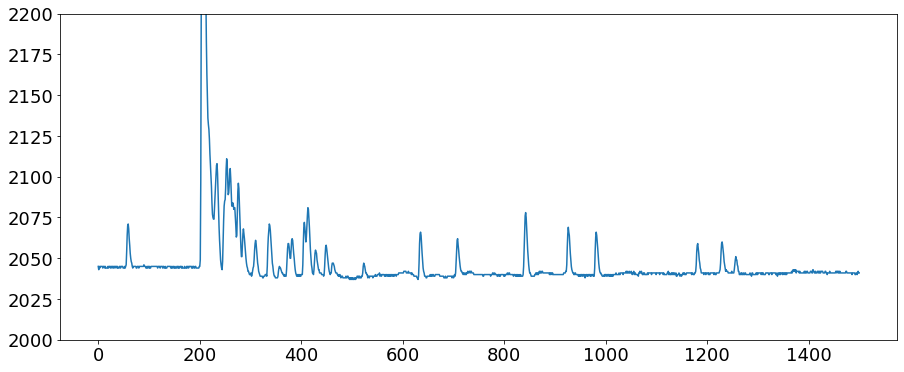

In [11]:
ctrA = 0
for idx,row in wfdf.iterrows():
    if (idx%100 != 0): continue
    print (idx)
    fig = plt.figure(figsize=(15,6))
    for pmt in range(26,27):
        plt.plot(row['wf_%02i'%pmt] + (pmt-26)*10)
    plt.ylim([2000,2200])
    plt.show()
    ctrA += 1
    if (ctrA >= 10):
        break

In [12]:
# Plotting style file

plt.style.use("LateLightStyle.mplstyle")

## Data Analysis

### Calculating baseline value

wf_26


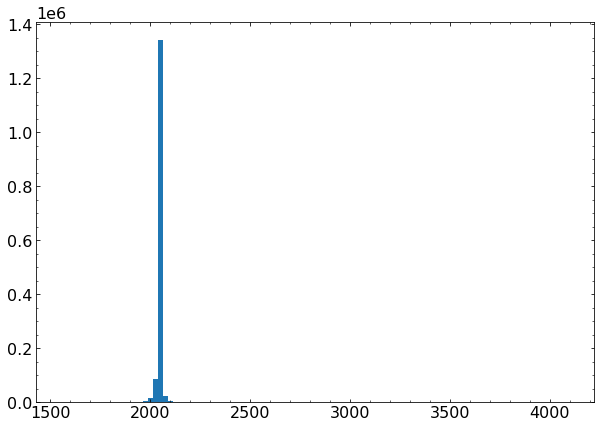

wf_27


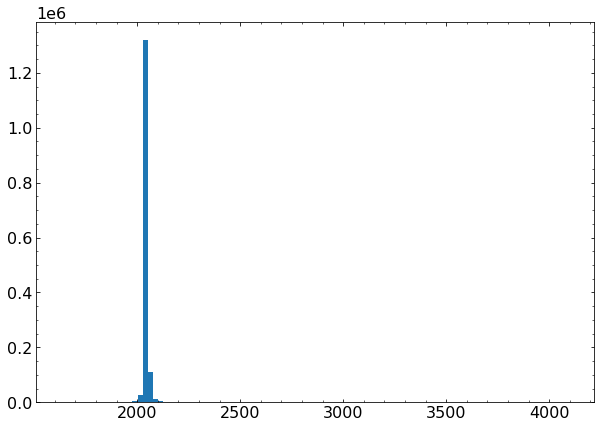

wf_28


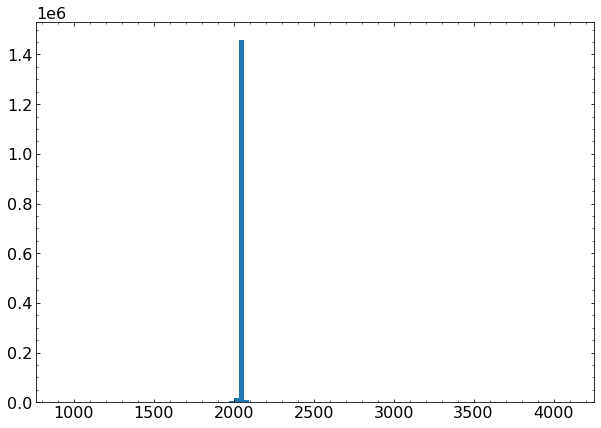

wf_29


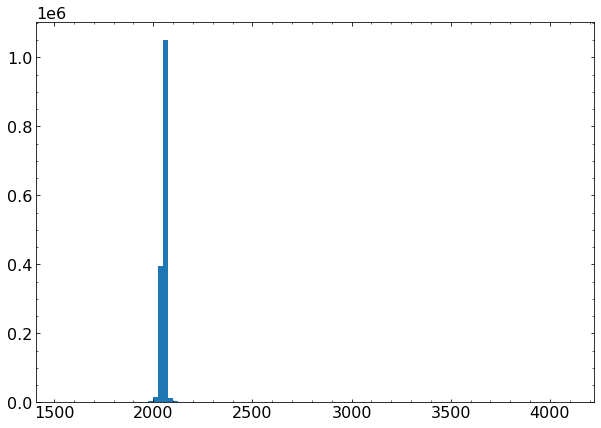

wf_30


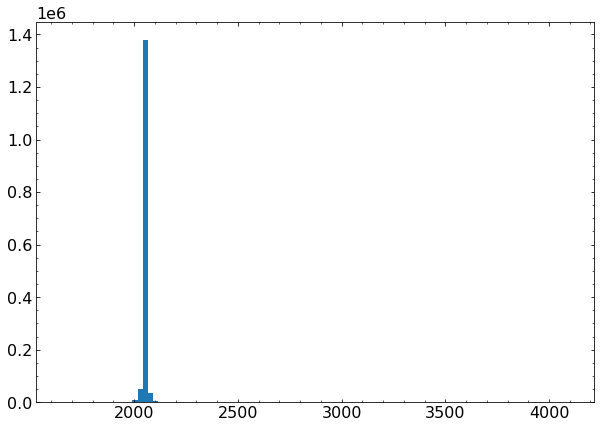

wf_31


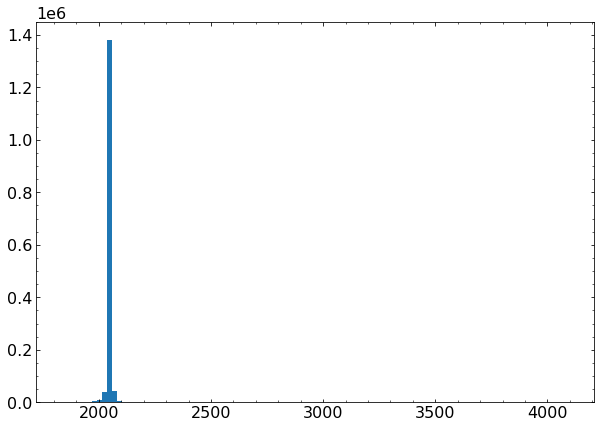

In [13]:
# plan for finding baseline: histogram, get the middle 1 or two sigma or sth

# histogram (linear scale) combining all the runs

for pmt in range(26,32):
    print(f"wf_{pmt}")
    wf_li = []
    for i in wfdf['wf_%02i'%pmt][0:1000]:
        for j in list(i):
            wf_li.append(j)

    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(wf_li, bins=100)
    plt.show()

wf_26


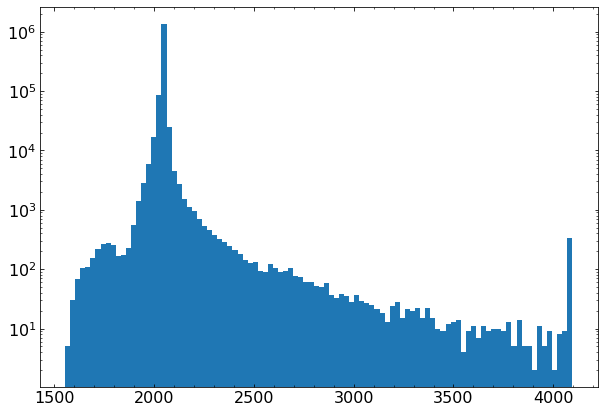

wf_27


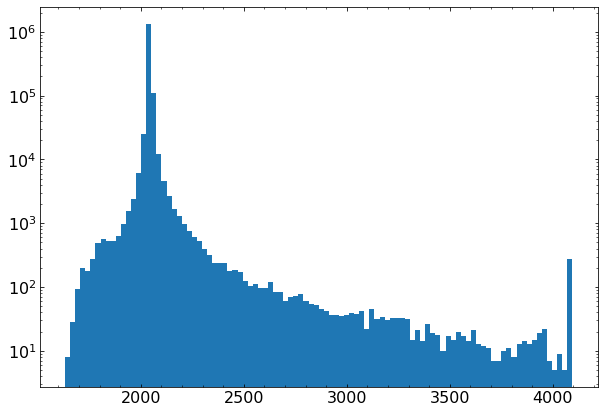

wf_28


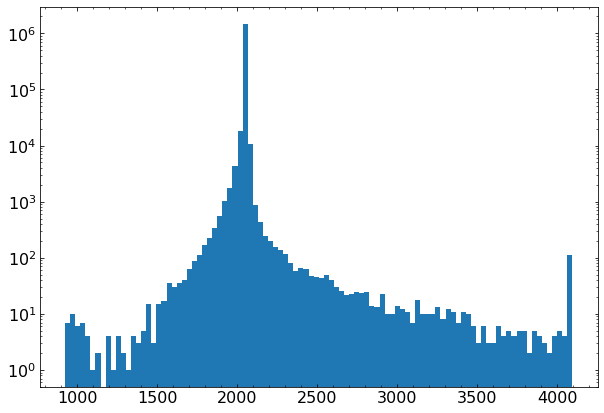

wf_29


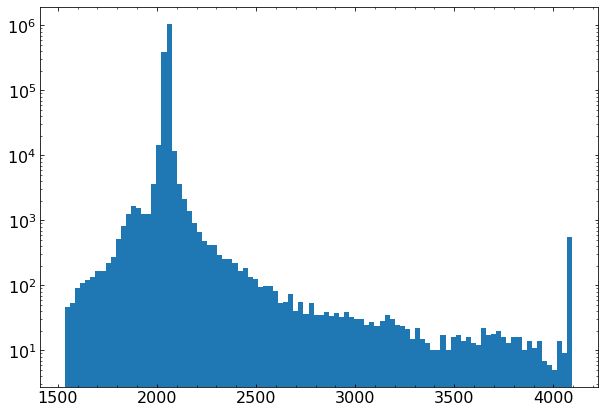

wf_30


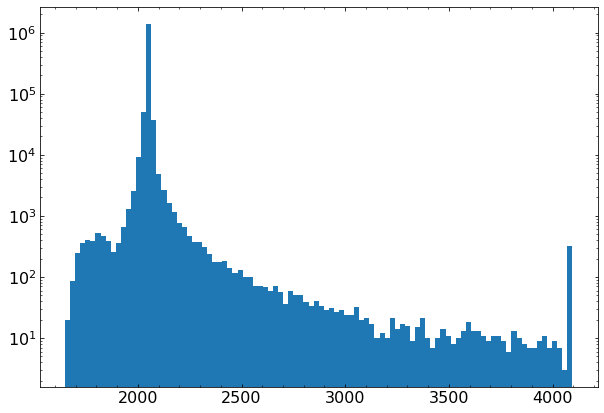

wf_31


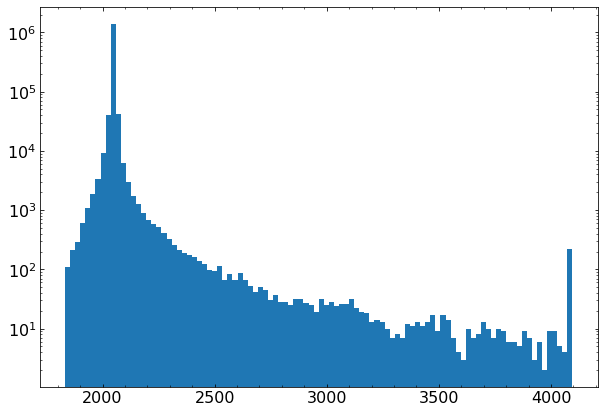

In [14]:
# histogram (log scale) combining all the runs

for pmt in range(26,32):
    print(f"wf_{pmt}")
    wf_li = []
    for i in wfdf['wf_%02i'%pmt][0:1000]:
        for j in list(i):
            wf_li.append(j)

    fig, ax = plt.subplots(figsize =(10, 7))
    ax.set_yscale("log")
    ax.hist(wf_li, bins=100)
    plt.show()

In [16]:
# Function for calculating the baseline and rms

def baseline(data, init):
    baseline = np.mean(data[0:init])
    rms = np.sqrt(np.sum([(i-baseline)**2 for i in data])/len(data))
    return baseline, rms

# Version 1: Function for detecting waveforms (mostly SPEs, assmuing anything larger than 1 sigma is a valid waveform)
# Version 2: Function for detecting SPE (Assuming SPE resides between 10-30 ADU (based on the distribution of amplitudes))

def SPE(data, baseline, rms, init):
    waveform = []
    amp = []
    area = []
    period = []
    i = 0
    while i < len(data[init:]):
        cache = []
        if 30>data[i]-baseline>10:
            # Adding an arbitrary value for waveforms with bad beginning
            if len(data[i-10:i-1])!=0 and max([abs(j-baseline) for j in data[i-10:i-1]])<rms:
                cache.extend(data[i-10:i-1])
            else:
                for j in range(len(data[i-10:i-1])):
                    cache.extend([baseline])
            while data[i]-baseline>10 and i in range(len(data[init:])):
                cache.append(data[i])
                i += 1
            cache.extend(data[i+1:i+10])
        else:
            pass
        # Why are things all below baseline?
        if len(cache) != 0 and max(cache)-baseline<30 and min(cache)-baseline>=-10:
            waveform.append(cache-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
        else:
            pass
        i += 1
    return waveform, amp, area, period, baseline, rms

In [17]:
# Function for calculating the baseline and rms

def baseline(data, init):
    baseline = np.mean(data[0:init])
    rms = np.sqrt(np.sum([(i-baseline)**2 for i in data])/len(data))
    return baseline, rms

# Version 1: Function for detecting waveforms (mostly SPEs, assmuing anything larger than 1 sigma is a valid waveform)
# Version 2: Function for detecting SPE (Assuming SPE resides between 10-30 ADU (based on the distribution of amplitudes))

# Alternate Version

def SPE(data, baseline, rms, init):
    waveform = []
    amp = []
    area = []
    period = []
    i = 0
    while i < len(data[init:]):
        cache = []
        if 30>data[i]-baseline>10:
            if len(data[i-10:i-1])!=0 and -rms<np.mean([j-baseline for j in data[i-10:i-1]])<rms:
                cache.extend(data[i-10:i-1])
                while data[i]-baseline>10 and i in range(len(data[init:])):
                    cache.append(data[i])
                    i += 1
                cache.extend(data[i+1:i+10])
            else:
                pass
        else:
            pass
        # Why are things all below baseline?
        if len(cache) != 0 and max(cache)-baseline<30:
            waveform.append(cache-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
        else:
            pass
        i += 1
    return waveform, amp, area, period, baseline, rms

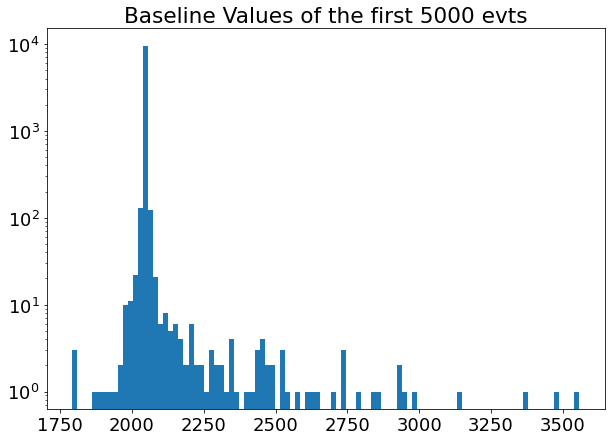

In [22]:
# Calculate baseline and RMS for each evt separately

baseline_li = []

# Use the first 100 data points as baseline
init_time = 100

for i in wfdf["wf_26"][0:10000]:
    baseline_li.append(baseline(i,init_time))

baseline_arr = np.asarray(baseline_li)

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(baseline_arr[:,0], bins=100)
ax.set_title("Baseline Values of the first 10000 evts")
plt.show()

(2045.3459251769464, 3.5865423720506553)
[[2.04593000e+03 2.08954700e+00]
 [2.04575000e+03 2.82320740e+00]
 [2.04486000e+03 1.52445837e+00]
 ...
 [2.04496000e+03 2.02719511e+00]
 [2.04498000e+03 3.68764785e+00]
 [2.04492000e+03 2.53418758e+00]]


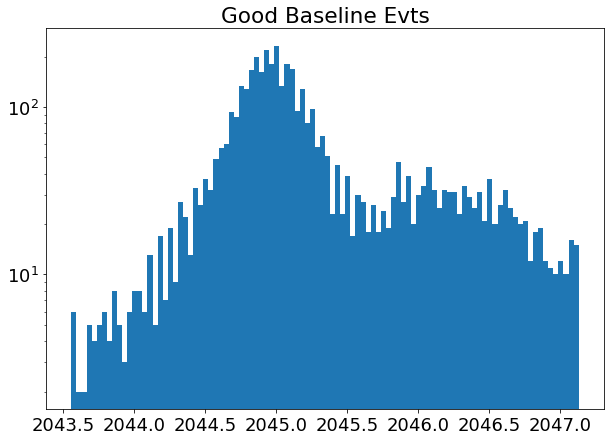

In [19]:
# Exclude the evts with bad baselines (take the middle 2 sigma of the baseline distribution)
# First simply exclude bad baselines with hard parameter

bsline_rough = [list(i) for i in baseline_arr if 2000<i[0]<2100]
bsline_rough = np.asarray(bsline_rough)

bslin_mean = baseline(bsline_rough[:,0], len(bsline_rough[:,0]))
print(bslin_mean)

# try list comprehension

bslin_good = [list(i) for i in baseline_arr if bslin_mean[0]-bslin_mean[1]*0.5<i[0]<bslin_mean[0]+bslin_mean[1]*0.5]
bslin_good = np.asarray(bslin_good)

print(bslin_good)

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(bslin_good[:,0], bins=100)
ax.set_title("Good Baseline Evts")
plt.show()

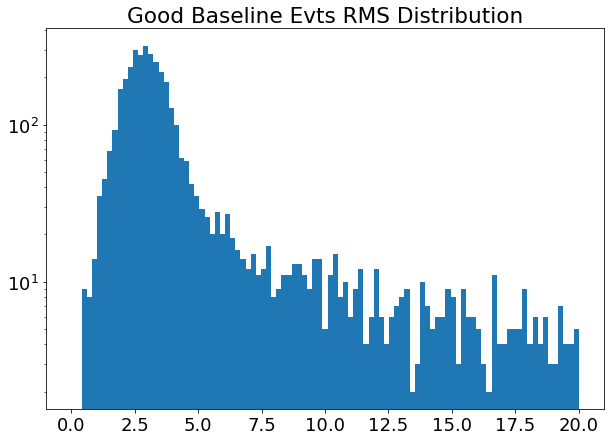

In [20]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(bslin_good[:,1], bins=np.linspace(0,20,100))
ax.set_title("Good Baseline Evts RMS Distribution")
plt.show()

In [20]:
# SPE Analysis

SPE_arr = []

for i in range(len(wfdf["wf_26"][0:1000])):
    SPE_arr.append(np.asarray(SPE(wfdf["wf_26"][i],baseline_arr[i,0],baseline_arr[i,1],init_time)))


F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


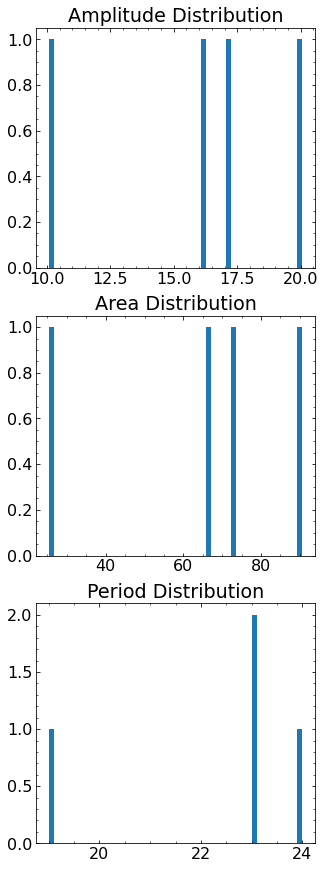

In [21]:
# Histogram of different parameters from one evt

fig, axs = plt.subplots(3, figsize=(5,15))
#ax.set_yscale("log")
axs[0].hist(SPE_arr[0][1], bins=50)
axs[0].set_title("Amplitude Distribution")
axs[1].hist(SPE_arr[0][2], bins=50)
axs[1].set_title("Area Distribution")
axs[2].hist(SPE_arr[0][3], bins=50)
axs[2].set_title("Period Distribution")
plt.show()

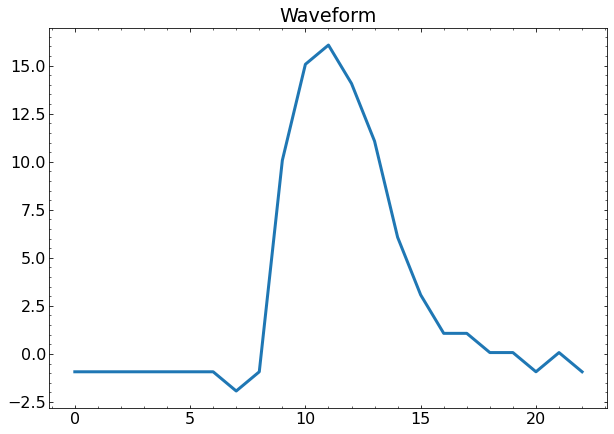

In [22]:
# Waveform for one SPE in one evt

fig, ax = plt.subplots(figsize =(10, 7))
#ax.set_yscale("log")
ax.plot(SPE_arr[0][0][0])
ax.set_title("Waveform")
plt.show()

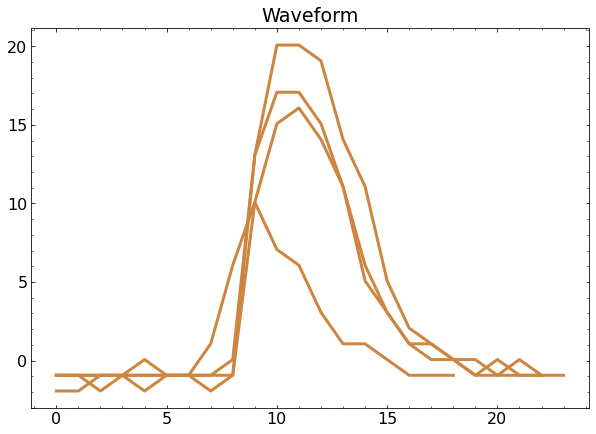

In [23]:
# Waveform for all the SPE in one evt
# TODO: line their peaks up (figure out why)

fig, ax = plt.subplots(figsize =(10, 7))
#ax.set_yscale("log")
for i in SPE_arr[0][0]:
    ax.plot(i, color="peru")
ax.set_title("Waveform")
plt.show()

In [24]:
# Detecting waveforms

# quick note:
# calculate the system's baseline with some small delta t at the beginning of each waveform
# each row in the array is a separate random trigger evt, baseline shoube different for each evt
# finding SPE pulse: get some threshold, interate through waveform, find when it exceeds and goes below the threshold

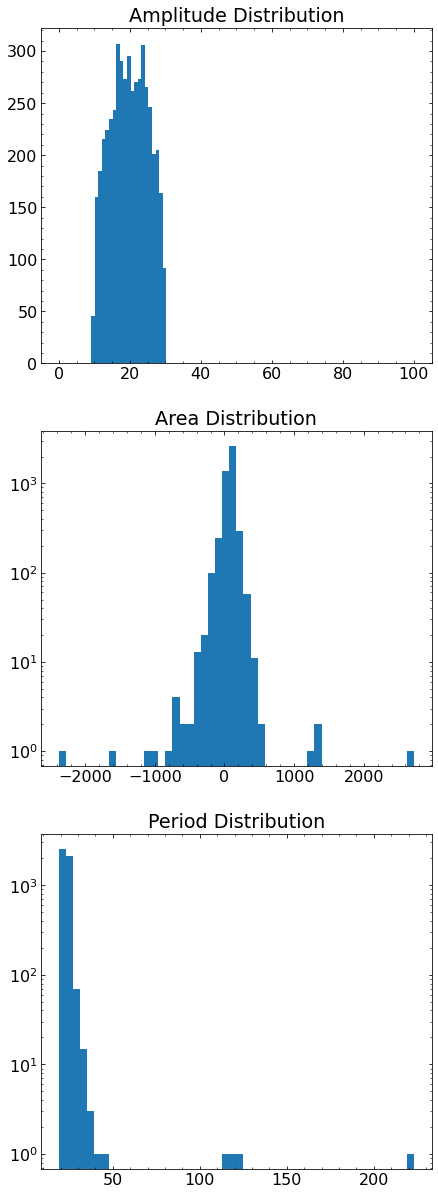

In [25]:
# Making the same figures for all available evts

amp_li = []
area_li = []
period_li = []

for i in SPE_arr:
    amp_li.extend(i[1])
    area_li.extend(i[2])
    period_li.extend(i[3])


# TODO: Set threshold according to amplitude distribution
fig, axs = plt.subplots(3, figsize=(7,21))
axs[0].hist(amp_li, bins=np.linspace(0,100,100))
axs[0].set_title("Amplitude Distribution")
#axs[0].set_yscale("log")
axs[1].hist(area_li, bins=50)
axs[1].set_title("Area Distribution")
axs[1].set_yscale("log")
axs[2].hist(period_li, bins=50)
axs[2].set_title("Period Distribution")
axs[2].set_yscale("log")
plt.show()

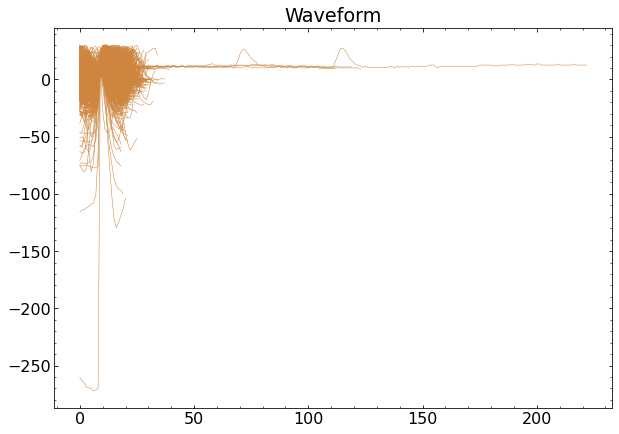

In [26]:
# Plotting waveforms from all events
# TODO: The margins are too small for larger waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_arr)):
    for j in SPE_arr[i][0]:
        ax.plot(j, color="peru", linewidth=0.5)
        
ax.set_title("Waveform")
plt.show()

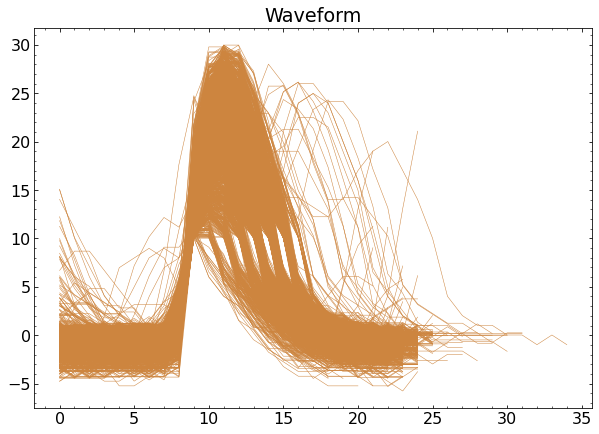

SPE detected 1875


In [27]:
# Plotting waveforms from all events
# 15.625ns per tick
# TODO: line their peaks up (figure out why)
# TODO: The margins are too small for larger waveforms
# Problem: A bunch of strange waveforms that may have been in the middle of other big waveforms; 
# Also some waveforms are not isolated well
# TODO: IMPORTANT bad baselines are not isolated

# exclude bad baseline evts

# When the limit is set at abs(i[5])<2.55, there's no more clear outliers, but there are only 98 waveforms left

SPE_good = [i for i in SPE_arr if bslin_mean[0]-bslin_mean[1]*1<i[4]<bslin_mean[0]+bslin_mean[1]*1 and abs(i[5])<5]
#SPE_good = np.asarray(SPE_good)

SPE_selected = []

a = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_good)):
    for k in range(len(SPE_good[i][1])):
        if abs(np.mean(SPE_good[i][0][k][-10:-1])) < SPE_good[i][5]:
            #ax.plot(SPE_good[i][0][k], color="peru", linestyle="none", marker=".")
            SPE_selected.append(SPE_good[i][0][k])
            ax.plot(SPE_good[i][0][k], color="peru", linewidth=0.5)
            a += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()

print(f"SPE detected {a}")

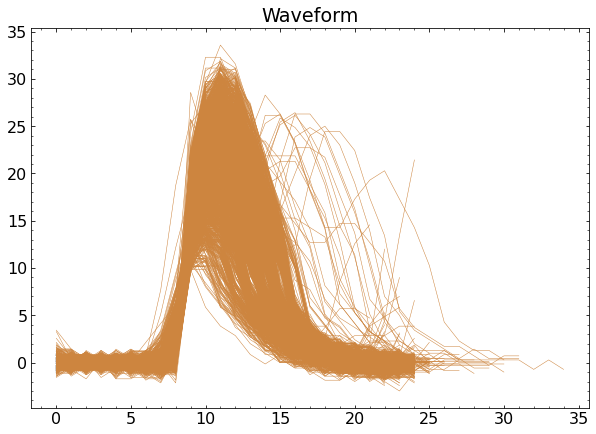

1822


In [28]:
# Align all the waveforms and exclude ones with outlier beginnings

SPE_mod = []

for i in SPE_selected:
    if max(i[:7])<=2.5:
        bslin_temp = np.mean(i[:7])
        SPE_mod.append(i-bslin_temp)
    else:
        pass

b = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_mod)):
    ax.plot(SPE_mod[i], color="peru", linewidth=0.5)
    b += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()
print(b)

In [33]:
# Simple fit function

# for a completely rectangular data array
'''
def mean_fit(data_arr):
    mean_wf = []
    for i in range(len(data_arr[0])):
        data_pts = [j for j in data_arr[:][i]]
        mean_wf.append(np.mean(data_pts))
    return mean_wf
'''

# Given the non-uniformity of the current waveforms, we have the following fit function: 
def mean_fit(data_arr):
    mean_wf = []
    i = 0
    while True:
        try:
            # Think of a way to take the average of less and less waveforms
            mean_wf.append(np.mean([data_arr[j][i] for j in range(len(data_arr))]))
        # Try to find the specific error instead of having only except
        except:
            break
        i += 1
    return mean_wf

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


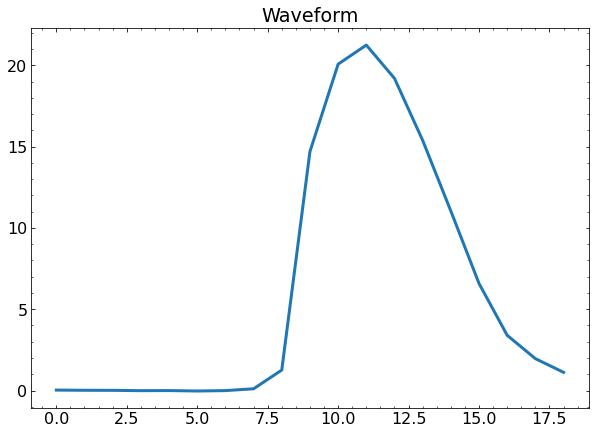

In [30]:
# Calculate the fit and plot it

SPE_mod_arr = np.asarray(SPE_mod)

fit_mean = mean_fit(SPE_mod_arr)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(fit_mean)
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()

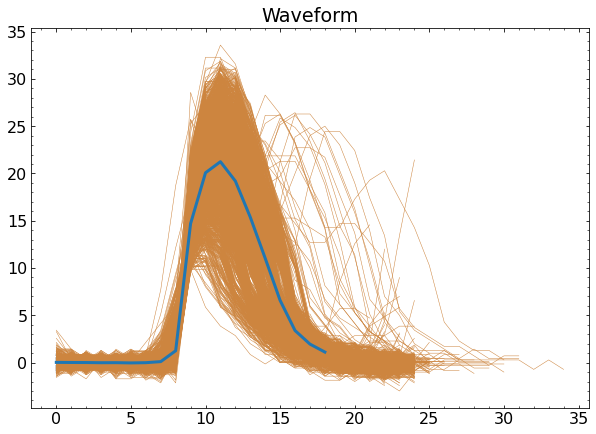

In [31]:
# Plot the fit together with the selected waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_mod)):
    ax.plot(SPE_mod[i], color="peru", linewidth=0.5)
#ax.set_xlim([0,100])
ax.plot(fit_mean)
ax.set_title("Waveform")
plt.show()

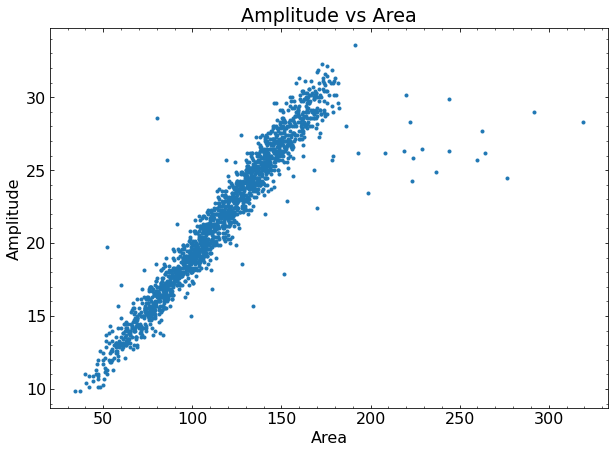

In [32]:
# Plotting amplitude distribution in relationship to area for the chosen waveforms

# This could be considered as redundant, generate these while making SPE_mod if code needs clean-up
SPE_mod_area = [sum(i) for i in SPE_mod]
SPE_mod_amp = [max(i) for i in SPE_mod]

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPE_mod_area, SPE_mod_amp, linestyle="none", marker=".")
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

In [13]:
# Reparse SPE events with new parameter

# Make sure there's no  extra pulses in some arbitrary ticks after the pulse

def SPE_tail(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    i = 0
    while i < len(data[init:]):
        cache = []
        if 30>data[i]-baseline>10:
            if abs(rms)<=5 and -rms<np.mean([j-baseline for j in data[i-10:i-1]])<rms:
                cache.extend(data[i-10:i-1])
                while data[i]-baseline>10 and i in range(len(data[init:])):
                    cache.append(data[i])
                    i += 1
                # end of the waveform here is defined as i+4 by observation
                if max(data[i+4:i+4+after]-baseline) <= 4*rms and len(data[i+4:i+4+after])==after:
                    cache.extend(data[i+1:i+4+after])
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0 and max(cache)-baseline<30:
            waveform.append(cache-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
        else:
            pass
        i += 1
    return waveform, amp, area, period, baseline, rms

In [23]:
SPEtail_arr = []

for i in range(len(wfdf["wf_26"][0:10000])):
    SPEtail_arr.append(np.asarray(SPE_tail(wfdf["wf_26"][i],baseline_arr[i,0],baseline_arr[i,1],init_time, 200)))

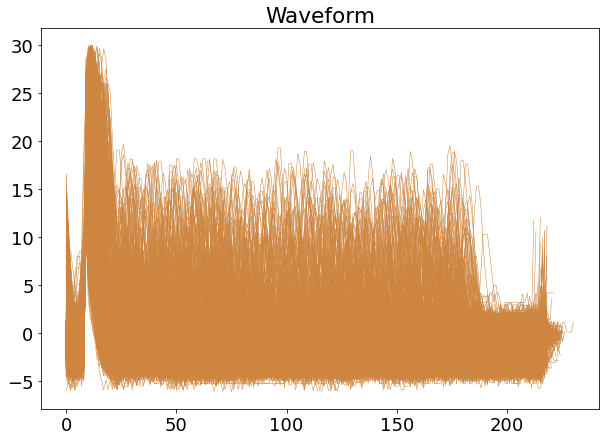

SPE detected 12186


In [24]:
# Plot all waveforms found with good baseline and rms

SPEtail_good = [i for i in SPEtail_arr if bslin_mean[0]-bslin_mean[1]*1<i[4]<bslin_mean[0]+bslin_mean[1]*1 and abs(i[5])<5]
#SPEtail_good = np.asarray(SPEtail_good)

SPEtail_selected = []

a = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_good)):
    for k in range(len(SPEtail_good[i][1])):
        if abs(max(SPEtail_good[i][0][k][-30:-1])) < SPEtail_good[i][5]:
            #ax.plot(SPEtail_good[i][0][k], color="peru", linestyle="none", marker=".")
            SPEtail_selected.append(SPEtail_good[i][0][k])
            ax.plot(SPEtail_good[i][0][k], color="peru", linewidth=0.5)
            a += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()

print(f"SPE detected {a}")

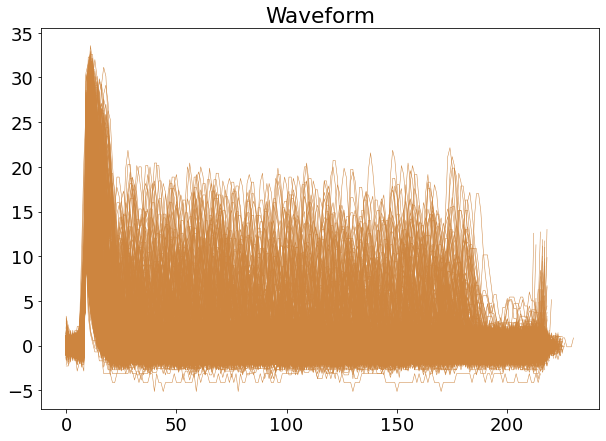

SPE selected 11930


In [25]:
# Align all the waveforms and exclude ones with outlier beginnings

SPEtail_mod = []

for i in SPEtail_selected:
    if max(i[:7])<=2.5:
        bslin_temp = np.mean(i[:7])
        SPEtail_mod.append(i-bslin_temp)
    else:
        pass

b = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_mod)):
    ax.plot(SPEtail_mod[i], color="peru", linewidth=0.5)
    b += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()
print(f"SPE selected {b}")

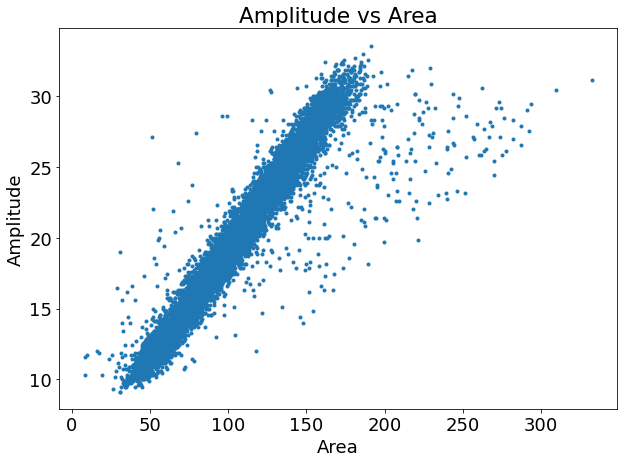

In [26]:
# Plotting amplitude distribution in relationship to area for the SEGMENTED chosen waveforms

# This could be considered as redundant, generate these while making SPE_mod if code needs clean-up
SPEtail_mod_area = [sum(i[0:25]) for i in SPEtail_mod]
SPEtail_mod_amp = [max(i[0:25]) for i in SPEtail_mod]

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEtail_mod_area, SPEtail_mod_amp, linestyle="none", marker=".")
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

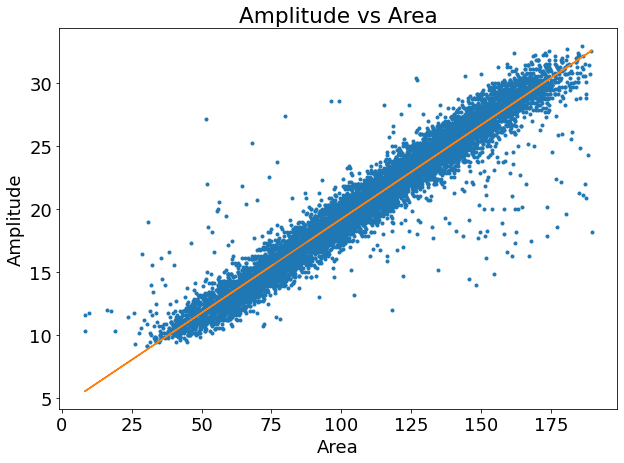

In [27]:
# Create a linear fit for Amplitude vs Area

# Manually exclude outliers before fitting

SPEtail_mod_amp = [SPEtail_mod_amp[i] for i in range(len(SPEtail_mod_amp)) if 0<SPEtail_mod_area[i]<190]
SPEtail_mod_area = [i for i in SPEtail_mod_area if 0<i<190]

amplinfit = np.poly1d(np.polyfit(SPEtail_mod_area,SPEtail_mod_amp,1))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEtail_mod_area, SPEtail_mod_amp, linestyle="none", marker=".")
ax.plot(SPEtail_mod_area, [amplinfit(i) for i in SPEtail_mod_area])
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

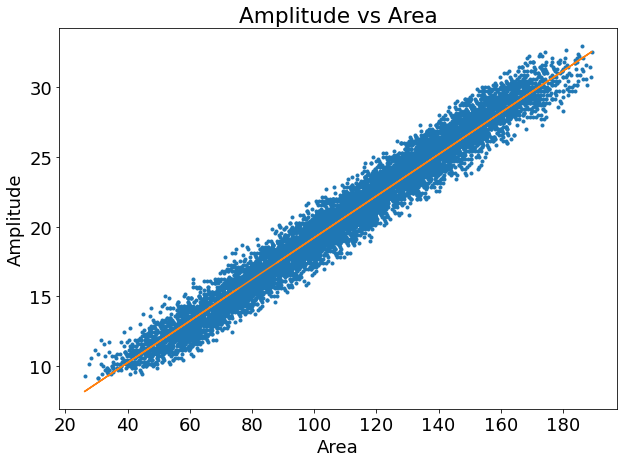

In [28]:
# Exlude outlier waveforms based on the amplitude vs area fit

SPEtail_modfit = []
SPEtail_modfit_area = []
SPEtail_modfit_amp = []

for i in range(len(SPEtail_mod_amp)):
    if abs(SPEtail_mod_amp[i]-amplinfit(SPEtail_mod_area[i])) < 3:
        SPEtail_modfit.append(SPEtail_mod[i])
        SPEtail_modfit_area.append(SPEtail_mod_area[i])
        SPEtail_modfit_amp.append(SPEtail_mod_amp[i])

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEtail_modfit_area, SPEtail_modfit_amp, linestyle="none", marker=".")
ax.plot(SPEtail_modfit_area, [amplinfit(i) for i in SPEtail_modfit_area])
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

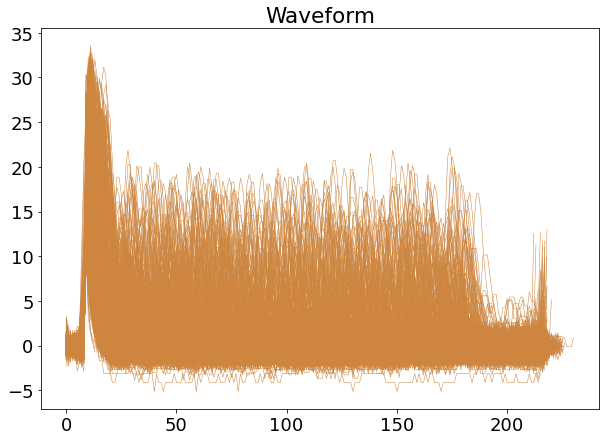

SPE selected 11605


In [29]:
# Selected waveforms

b = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_modfit)):
    ax.plot(SPEtail_modfit[i], color="peru", linewidth=0.5)
    b += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()
print(f"SPE selected {b}")

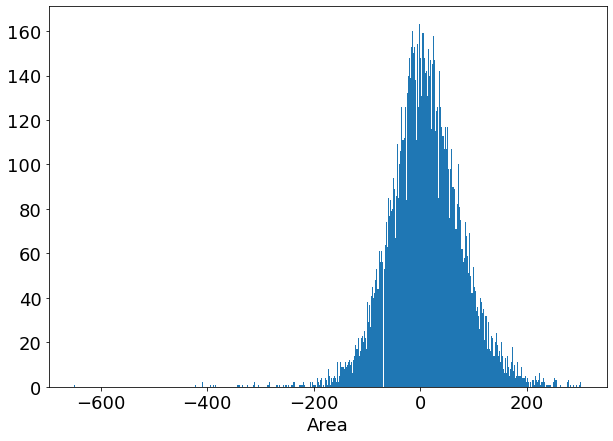

In [30]:
# Afterpulse area distribution

aftersum = [sum(i[15:]) for i in SPEtail_modfit]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(aftersum, bins=500)
ax.set_xlabel("Area")
plt.show()

In [31]:
# Exclude waveforms with bad afterpulses and do some final cleanup

afteravg, afterrms = baseline(aftersum, len(aftersum))

print(afterrms)

SPE_clean = []

for i in range(len(SPEtail_modfit)):
    if afteravg-afterrms < aftersum[i] < afteravg+afterrms and max(SPEtail_modfit[i][20:])<2.0:
        SPE_clean.append(SPEtail_modfit[i])
    else:
        pass

SPE_clean = np.array(SPE_clean)

print(len(SPE_clean))

68.72088474856048
6913


<ipython-input-31-687696b8bc23>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  SPE_clean = np.array(SPE_clean)


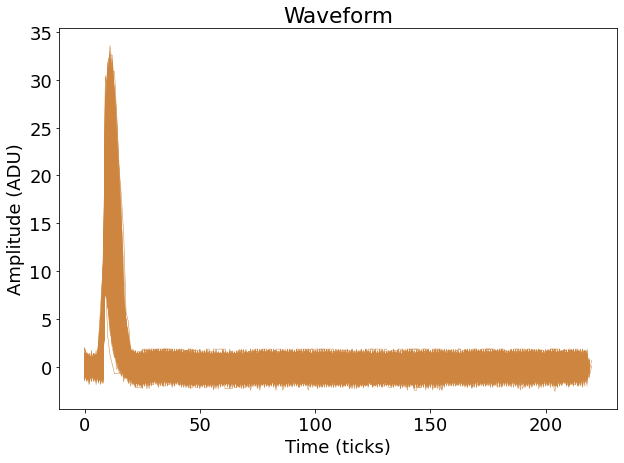

In [34]:
fit_mean_tail= mean_fit(SPE_clean)

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_clean)):
    ax.plot(SPE_clean[i], color="peru", linewidth=0.5)
#ax.plot(fit_mean_tail)
#ax.set_xlim([0,20])
ax.set_title("Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.show()

In [35]:
%store SPE_clean

Stored 'SPE_clean' (ndarray)


In [45]:
from scipy import optimize

[21.63752788  9.06930517  5.38795288]
[[ 0.09342045 -0.39188935 -0.01211744]
 [-0.39188935  8.08226749  0.29914187]
 [-0.01211744  0.29914187  0.01165872]]


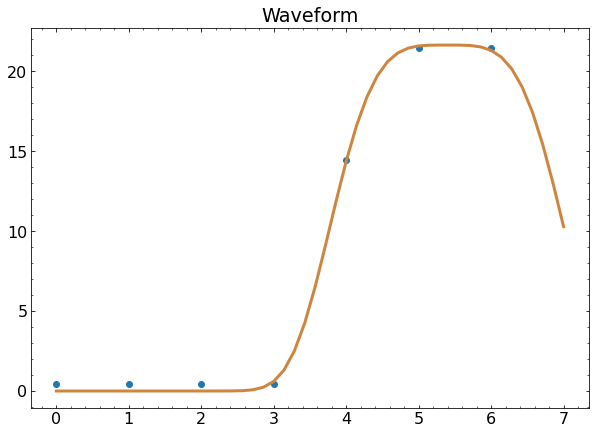

In [46]:
# fitting function

'''
def MCK_func(t,t0,x0,a,A,tau,tau_slow):
    return np.piecewise(t,[t<=t0, t>t0],[x0, x0+a(t-t0)**3*np.exp(-(t-t0)/tau)-A*np.exp(-(t-t0)/tau_slow)])

t0_c, x0_c, a_c, A_c, tau_c, tau_slow_c = optimize.curve_fit(MCK_func, [i for i in range(len(SPEtail_modfit[0]))], SPEtail_modfit[0])
'''

def exp_func(t, A, B, t_0):
    return A*np.exp(-(t-t_0)**4/B)

pars, conv = optimize.curve_fit(f=exp_func, xdata=[i for i in range(7)], ydata=SPE_clean[0][5:12])

print(pars)
print(conv)


fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPE_clean[0][5:12], linestyle="none", marker="o")
ax.plot(np.linspace(0,7,num=50), [pars[0]*np.exp(-(i-pars[2])**4/pars[1]) for i in np.linspace(0,7,num=50)], color="peru")
ax.set_title("Waveform")
plt.show()

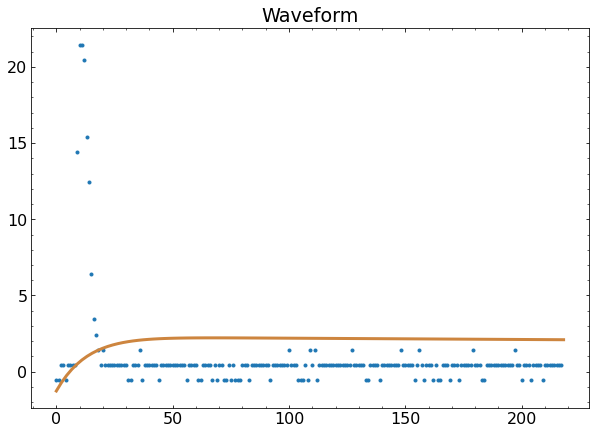

In [47]:
# different fitting function (the function by Mike S., Chi C., Kazu)

tau = 20.94
tau_slow = 110000
t0 = 105.3

def MCK_func(t,x0,a,A):
    return x0+(a*(t-t0)**3)*np.exp(-(t-t0)/tau)-A*np.exp(-(t-t0)/tau_slow)

params2, conv2 = optimize.curve_fit(f=MCK_func, xdata=[i*15.625 for i in range(len(SPE_clean[0]))], ydata=SPE_clean[0])

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPE_clean[0], linestyle="none", marker=".")
ax.plot([i for i in np.linspace(0,len(SPE_clean[0]),num=100)], [params2[0]+(params2[1]*(i-t0)**3)*np.exp(-(i-t0)/tau)-params2[2]*np.exp(-(i-t0)/tau_slow) for i in np.linspace(0,len(SPE_clean[0]),num=100)], color="peru")
ax.set_title("Waveform")
plt.show()

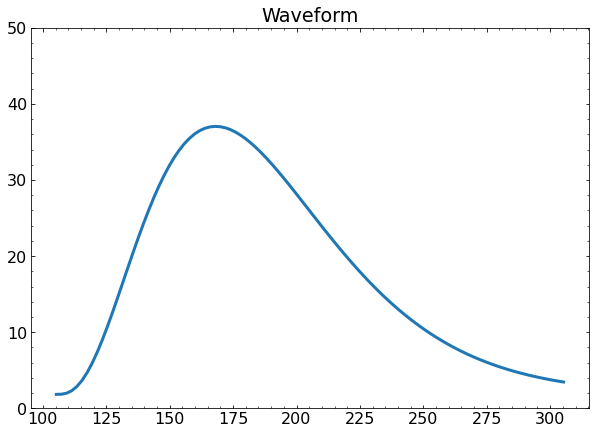

In [48]:
# Change units (time: 15.625ns per tick)
# exemplar function

tau = 20.94
tau_slow = 110000
t0 = 105.3
a = 2.853*10**(-3)
A = 4.988*10**(-3)
x0 = 1.835

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(np.linspace(t0,t0+200,num=100), [x0+(a*(i-t0)**3)*np.exp(-(i-t0)/tau)-A*np.exp(-(i-t0)/tau_slow) for i in np.linspace(t0,t0+200,num=100)])
ax.set_title("Waveform")
ax.set_ylim([0,50])
plt.show()

[[5.90758733e+04 1.03903248e-02 5.92103114e+04]
 [1.03903248e-02 4.11567333e-09 1.04204782e-02]
 [5.92103114e+04 1.04204782e-02 5.93451115e+04]]


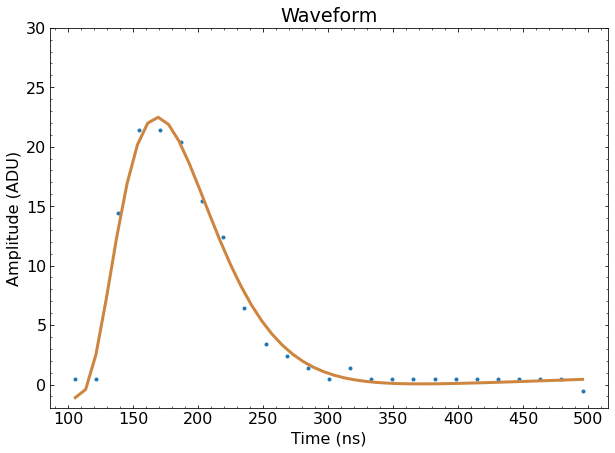

In [49]:
# different fitting function (the function by Mike S., Chi C., Kazu) with cropped data and added constants

tau = 20.94
tau_slow = 110000
t0 = 105.3

def MCK_func(t,x0,a,A):
    return x0+(a*(t-t0)**3)*np.exp(-(t-t0)/tau)-A*np.exp(-(t-t0)/tau_slow)

# parameters and their covariance
params2, conv2 = optimize.curve_fit(f=MCK_func, xdata=[i for i in np.linspace(t0,t0+25*15.625,num=25)], ydata=SPE_clean[0][7:32])

print(conv2)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=25)], SPE_clean[0][7:32], linestyle="none", marker=".")
ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=50)], [params2[0]+(params2[1]*(i-t0)**3)*np.exp(-(i-t0)/tau)-params2[2]*np.exp(-(i-t0)/tau_slow) for i in np.linspace(t0,t0+25*15.625,num=50)], color="peru")
ax.set_title("Waveform")
ax.set_ylim([-2,30])
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ns)")
plt.show()

In [50]:
# Functions for fitting all waveforms


# exp fitting
def exp_func(t, t_0, A, B):
    return A*np.exp(-(t-t_0)**4/B)

# a responsive exp fitting function that minimizes the distance between the fitted amplitude and amplitude from data
def exp_fit(waveform):
    pars_li = []
    conv_li = []
    for i in range(10):
        try:
            pars, conv = optimize.curve_fit(f=exp_func, xdata=np.linspace(0,9,num=9), ydata=waveform[i:i+9])
            pars_li.append(pars)
            conv_li.append(conv)
        except RuntimeError:
            pass
    # find the set of parameters that provide a minimum amplitude difference (find the analytic maximum of the function)
    diff = [abs(max(waveform) - i[1]) for i in pars_li]
    n = diff.index(min(diff))
    # last returned parameter is the location of the beginning of the fit
    return pars_li[n], np.sqrt(np.diag(conv_li[n])), n

[  5.90038462  23.26593429 115.62933673]


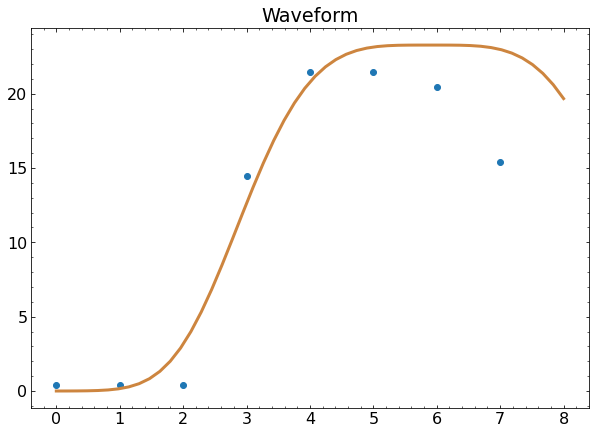

In [51]:
# Some trials with the exp fit revealed that this fit seems to be extremely prone to any miniscule prepulse
fit_out = exp_fit(SPE_clean[420])
test = fit_out[0]
loc = fit_out[2]
print(test)

fig, ax = plt.subplots(figsize =(10, 7))
# TODO: Should it be loc-1 or loc?
# Tentative answer: it doesn't really matter as long as the time constant is preserved
ax.plot(SPE_clean[0][loc:loc+8], linestyle="none", marker="o")
ax.plot(np.linspace(0,8,num=50), [exp_func(i, test[0], test[1], test[2]) for i in np.linspace(0,8,num=50)], color="peru")
ax.set_title("Waveform")
plt.show()

# IMPORTANT: right now all the time parameters are still in ticks not ns
# Also, is matching the value of amplitudes of fit and data the best way to find best fit? 

In [52]:
# fit to all SPE data
SPE_expfit = []
for i in SPE_clean:
    SPE_expfit.append(exp_fit(i))

print(len(SPE_expfit))

<ipython-input-50-c93db6fcee2b>:6: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-(t-t_0)**4/B)
F:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-50-c93db6fcee2b>:6: RuntimeWarning: overflow encountered in multiply
  return A*np.exp(-(t-t_0)**4/B)
<ipython-input-50-c93db6fcee2b>:23: RuntimeWarning: invalid value encountered in sqrt
  return pars_li[n], np.sqrt(np.diag(conv_li[n])), n


3457


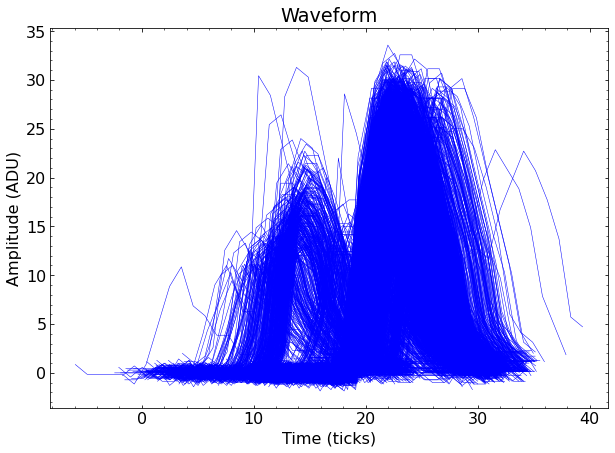

In [53]:
# Plotting out all the waveforms and their fits (raw fits)

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_expfit)):
    ax.plot([i+SPE_expfit[j][0][0] for i in np.linspace(5,25,num=20)], SPE_clean[j][0:20], linewidth=0.5, color="blue")
    #ax.plot([i for i in np.linspace(0,20,num=50)], [exp_func(i,SPE_expfit[j][0][0],SPE_expfit[j][0][1],SPE_expfit[j][0][2]) for i in np.linspace(0,20,num=50)], color="peru", alpha=0.5)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ticks)")
plt.show()

# Are these good enough? The rising edge doesn't seem to be captured perfectly

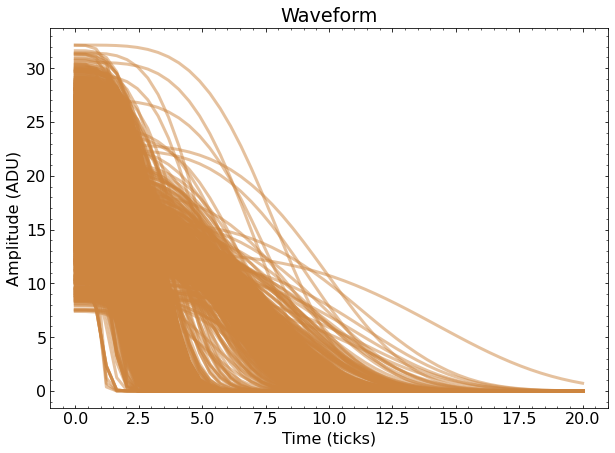

In [54]:
# Plotting out all the time aligned waveforms and time aligned fits 

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_expfit)):
    #ax.plot(SPE_clean[j][SPE_expfit[j][2]:SPE_expfit[j][2]+20], linewidth=0.5, color="blue")
    ax.plot([i for i in np.linspace(0,20,num=50)], [exp_func(i,0,SPE_expfit[j][0][1],SPE_expfit[j][0][2]) for i in np.linspace(0,20,num=50)], color="peru", alpha=0.5)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ticks)")
plt.show()

# Are these good enough? The rising edge doesn't seem to be captured perfectly

In [55]:
# MCK fitting
tau = 20.94
tau_slow = 110000


def MCK_func(t,a,A,t0):
    return (a*(t-t0)**3)*np.exp(-(t-t0)/tau)-A*np.exp(-(t-t0)/tau_slow)

def MCK_fit(waveform):
    pars2, conv2 = optimize.curve_fit(f=MCK_func, xdata=np.linspace(0,25*15.625,num=25), ydata=waveform[7:32])
    return pars2, np.sqrt(np.diag(conv2))

In [56]:
# Electing to use MCK fit for now

SPE_MCKfit = []

for i in SPE_clean:
    SPE_MCKfit.append(np.array(MCK_fit(i)))

print(len(SPE_MCKfit))

3457


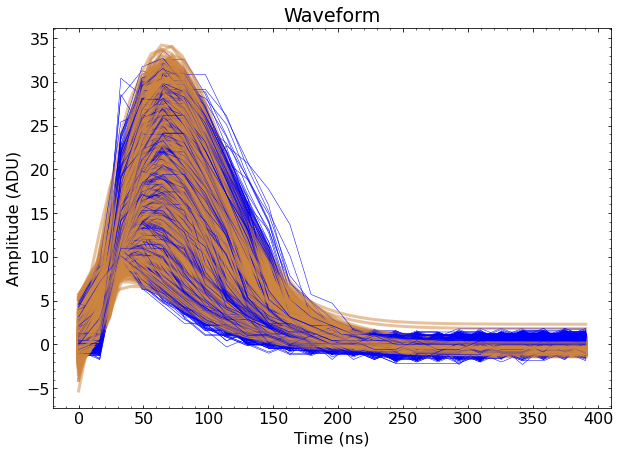

In [57]:
# Plotting out all the waveforms and their fits (raw fits)

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_MCKfit)):
    #ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=25)], SPEtail_modfit[j][7:32], linestyle="none", marker=".")
    ax.plot([i for i in np.linspace(0,25*15.625,num=25)], SPE_clean[j][7:32], linewidth=0.5, color="blue")
    ax.plot([i for i in np.linspace(0,25*15.625,num=50)], [MCK_func(i,SPE_MCKfit[j][0][0],SPE_MCKfit[j][0][1],SPE_MCKfit[j][0][2]) for i in np.linspace(0,25*15.625,num=50)], color="peru", alpha=0.5)
ax.set_title("Waveform")
#ax.set_ylim([-2,30])
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ns)")
plt.show()

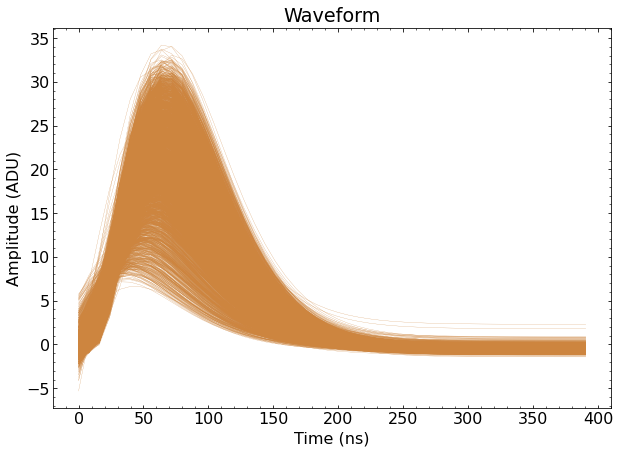

In [58]:
# Plotting out only the fits (not time aligned yet)

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_MCKfit)):
    #ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=25)], SPEtail_modfit[j][7:32], linestyle="none", marker=".")
    #ax.plot([i for i in np.linspace(0,25*15.625,num=25)], SPEtail_modfit[j][7:32], linewidth=0.5, color="blue")
    ax.plot([i for i in np.linspace(0,25*15.625,num=50)], [MCK_func(i,SPE_MCKfit[j][0][0],SPE_MCKfit[j][0][1],SPE_MCKfit[j][0][2]) for i in np.linspace(0,25*15.625,num=50)], color="peru", linewidth=0.2)
ax.set_title("Waveform")
#ax.set_ylim([-2,30])
ax.set_ylabel("Amplitude (ADU)")
ax.set_xlabel("Time (ns)")
plt.show()

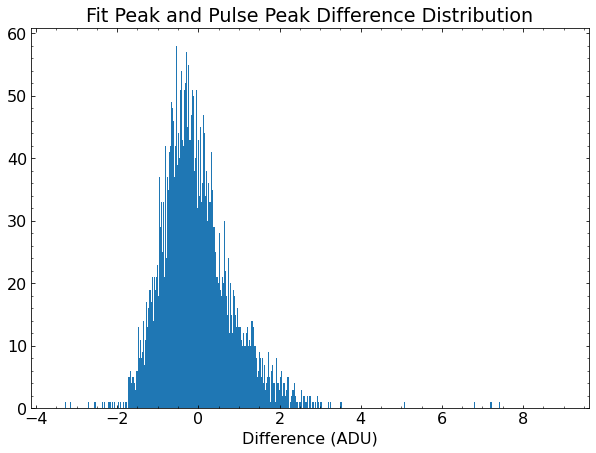

In [59]:
# Quick check on the quality of the fits

fig, ax = plt.subplots(figsize =(10, 7))
# Pulse peak - fit peak
ax.hist([max(SPE_clean[j][7:32])-max([MCK_func(i,SPE_MCKfit[j][0][0],SPE_MCKfit[j][0][1],SPE_MCKfit[j][0][2]) for i in np.linspace(0,25*15.625,num=50)]) for j in range(len(SPE_MCKfit))], bins=np.linspace(-3.5,9,500))
ax.set_title("Fit Peak and Pulse Peak Difference Distribution")
ax.set_xlabel("Difference (ADU)")
plt.show()

# How good is this?
# My current opinion: Not good enough, given that this fit will essentially be the actual measurement
# New Version now: This may no longer be a problem?

# Choices: Discard the ones with bad fit (There will be quite a bit of data loss)
# Or do a responsive fit (might be very slow)
# Or do piecewise fit (this might be the right way to make it very precise, but is that needed?)

[0.00181463 0.1188001  0.00589849]


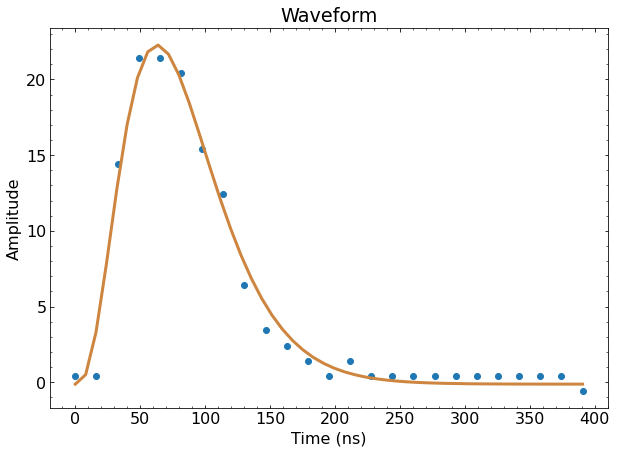

In [60]:
# Playground for improving MCK fit

n = 0

test2 = MCK_fit(SPE_clean[n])[0]
print(test2)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot([i for i in np.linspace(0,25*15.625,num=25)], SPE_clean[n][7:32], linestyle="none", marker="o")
ax.plot([i for i in np.linspace(0,25*15.625,num=50)], [MCK_func(i,SPE_MCKfit[n][0][0],SPE_MCKfit[n][0][1],SPE_MCKfit[n][0][2]) for i in np.linspace(0,25*15.625,num=50)], color="peru")
ax.set_title("Waveform")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (ns)")
plt.show()

In [61]:
# Time align the waveforms according to the fits

# align at maximum?
# normalize the index of the maximum data point?

MCKfit_arr = np.array([[MCK_func(i,SPE_MCKfit[j][0][0],SPE_MCKfit[j][0][1],SPE_MCKfit[j][0][2]) for i in np.linspace(0,25*15.625,num=50)] for j in range(len(SPE_MCKfit))])

# Plot the waveforms with their peaks aligned
# Second thought: this might not be the best idea, but I will save this array for now

In [62]:
# Peak align the fit curves in function space
# find max in curve, change t0 until the max point aligns with x=0 (e^(t+some offset))

import copy
from scipy.integrate import quad

MCKfit_params = copy.deepcopy(SPE_MCKfit)

for i in range(len(MCKfit_arr)):
    # Delete the time constant to align all the waveforms
    MCKfit_params[i][0][2] = 0
    # normalize all waveforms by area (normalziation constant here is (definite integral of the function)^-1)
    #MCKfit_params[i][0][0] /= max(MCKfit_arr[i])
    #MCKfit_params[i][0][1] /= max(MCKfit_arr[i])
    norm_const = quad(MCK_func, 0, 300, args=(MCKfit_params[i][0][0],MCKfit_params[i][0][1],MCKfit_params[i][0][2]))
    MCKfit_params[i][0][0] /= norm_const[0]
    MCKfit_params[i][0][1] /= norm_const[0]


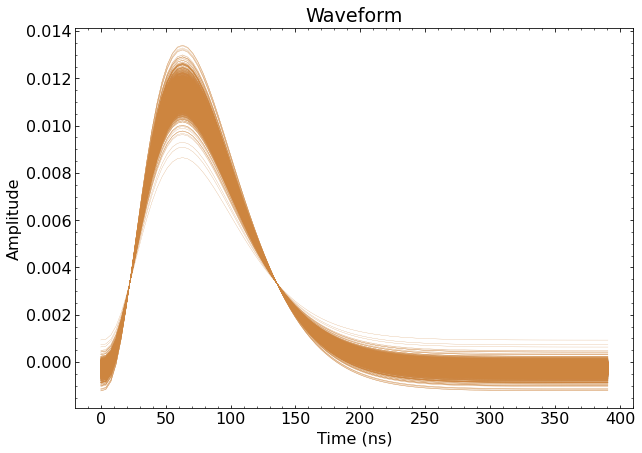

In [63]:
# Plot the peak aligned waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_MCKfit)):
    #ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=25)], SPEtail_modfit[j][7:32], linestyle="none", marker=".")
    #ax.plot([i for i in np.linspace(0,25*15.625,num=25)], SPEtail_modfit[j][7:32], linewidth=0.5, color="blue")
    ax.plot([i for i in np.linspace(0,25*15.625,num=100)], [MCK_func(i,MCKfit_params[j][0][0],MCKfit_params[j][0][1],MCKfit_params[j][0][2]) for i in np.linspace(0,25*15.625,num=100)], color="peru", linewidth=0.2)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (ns)")
plt.show()

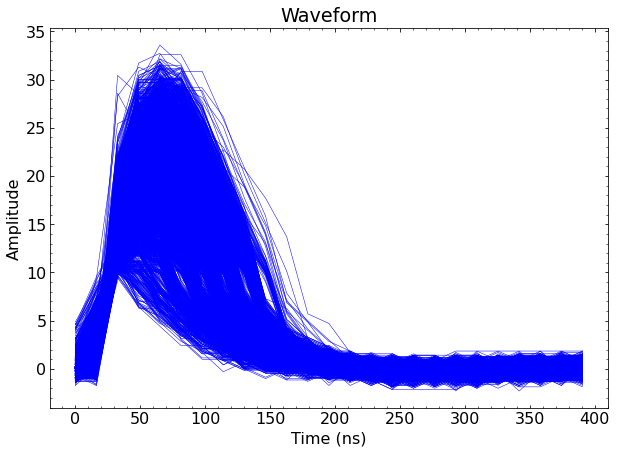

In [64]:
# Try out my current normalization method on the actual waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for j in range(len(SPE_MCKfit)):
    #ax.plot([i for i in np.linspace(t0,t0+25*15.625,num=25)], SPEtail_modfit[j][7:32], linestyle="none", marker=".")
    ax.plot([i for i in np.linspace(0,25*15.625,num=25)], SPE_clean[j][7:32], linewidth=0.5, color="blue")
    #ax.plot([i for i in np.linspace(0,25*15.625,num=100)], [MCK_func(i,MCKfit_params[j][0][0],MCKfit_params[j][0][1],MCKfit_params[j][0][2]) for i in np.linspace(0,25*15.625,num=100)], color="peru", linewidth=0.2)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (ns)")
plt.show()

### Building SPE Kernel

MCK fit

In [65]:
# create an empty SPE kernel 2d array
# 300 bins from 0ns to 300ns, bin size 1ns

# timespan = 300

kernel_arr = np.empty(shape=(300,), dtype=object)
print(kernel_arr[0])

None


In [66]:
# time correct and normalize the selected SPEs, then place them into their corresponding bins
# Doing all three steps in the same loop because all the varaibles are ready

for i in range(len(SPE_MCKfit)):
    #norm_const = quad(MCK_func, 0, 300, args=(SPE_MCKfit[i][0][0],SPE_MCKfit[i][0][1],SPE_MCKfit[i][0][2]))
    #norm_const = sum(SPE_clean[i][7:32])
    #norm_const = max(SPE_clean[i][7:32])
    norm_const = 1
    for j in range(len(SPE_clean[i])):
        n = int(round(j*15.625-SPE_MCKfit[i][0][2]))
        if n<300:
            kernel_arr[n] = np.append(kernel_arr[n], SPE_clean[i][j+7]/norm_const)
        else:
            pass

# How to deal with the none at the beginning?

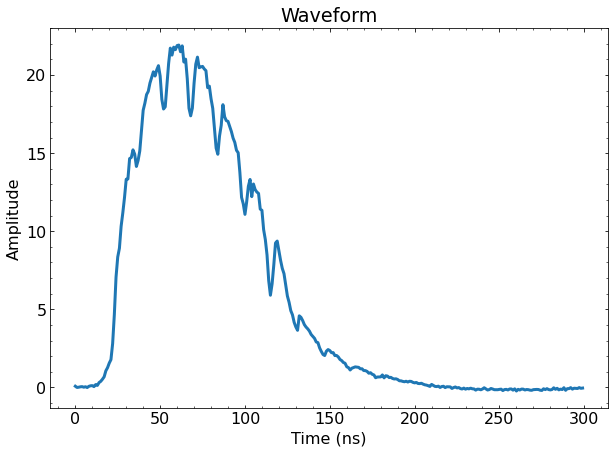

In [67]:
kernel_wf = [np.mean(i[1:]) for i in kernel_arr]
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kernel_wf)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (ns)")
ax.minorticks_on()
plt.show()

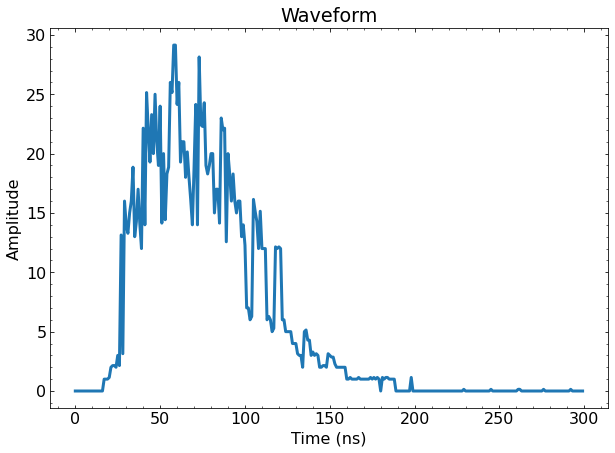

In [68]:
# what would happen if I plot mode?
kernel_wf1 = [max(set(list(i)), key=list(i).count) for i in kernel_arr]
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kernel_wf1)
ax.set_title("Waveform")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (ns)")
ax.minorticks_on()
plt.show()

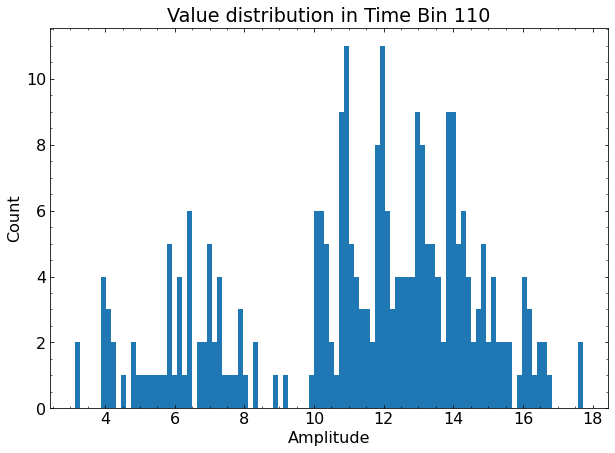

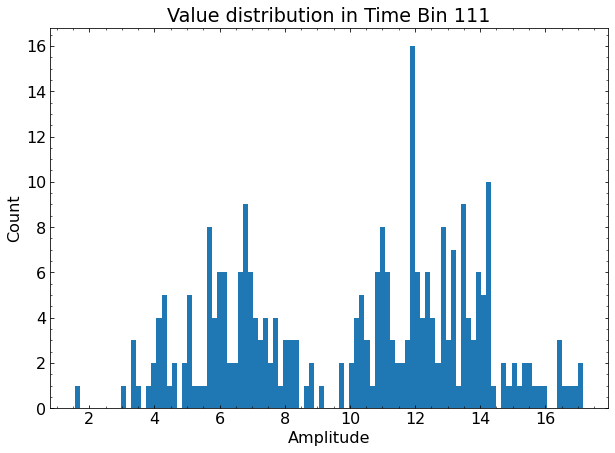

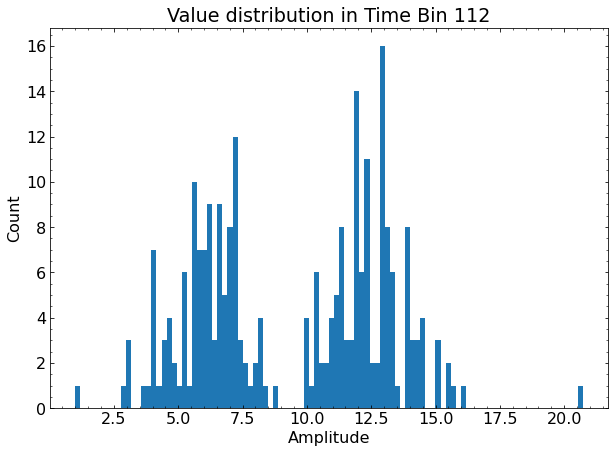

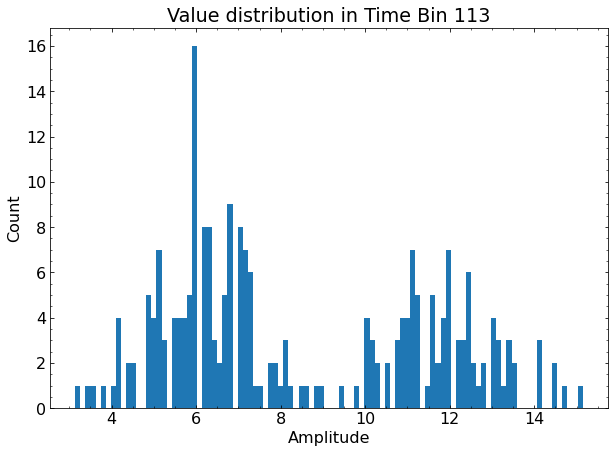

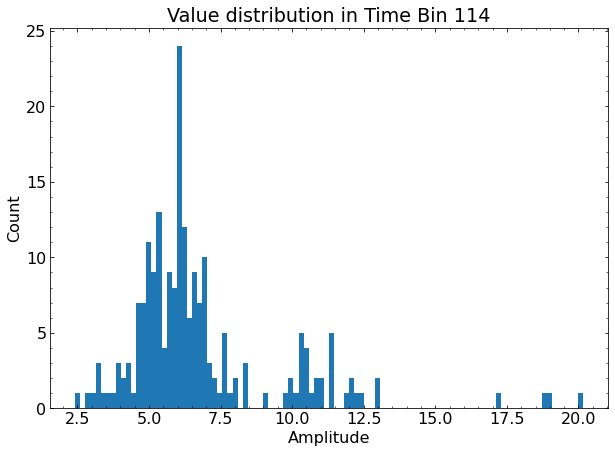

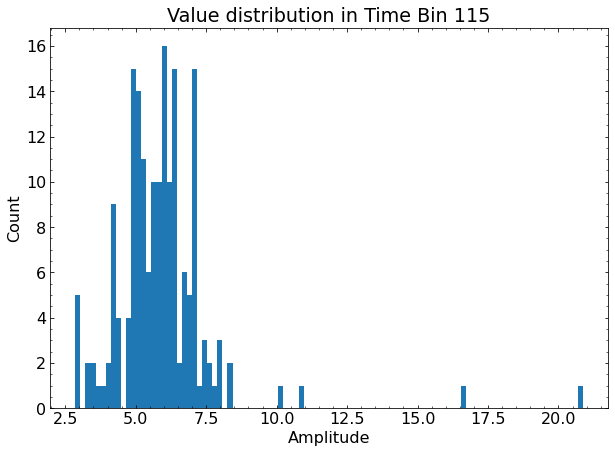

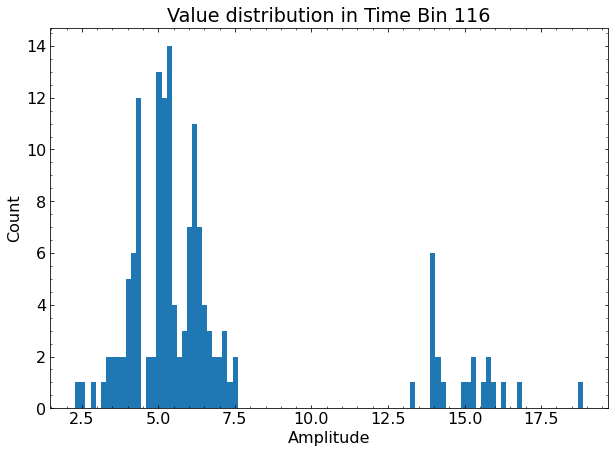

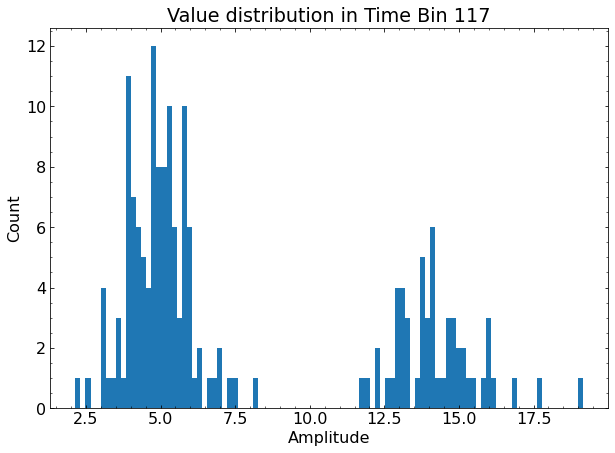

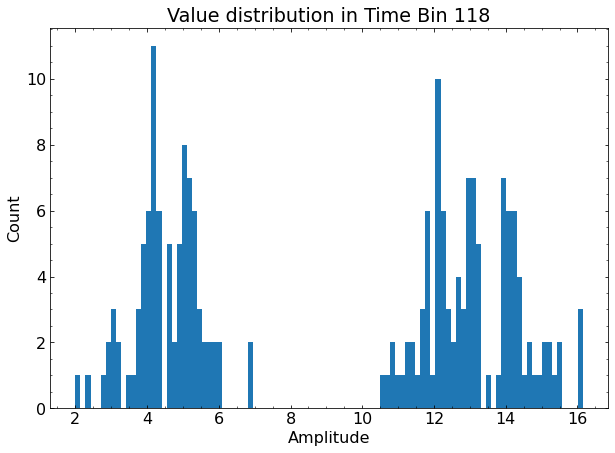

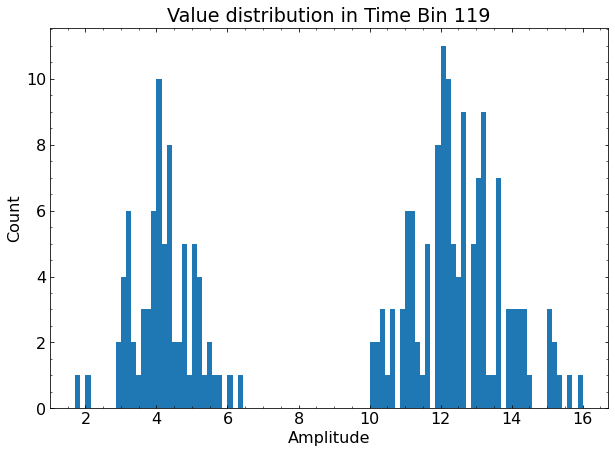

In [69]:
for i in range(110,120):
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(kernel_arr[i][1:], bins=100)
    ax.set_title(f"Value distribution in Time Bin {i}")
    ax.set_xlabel("Amplitude")
    ax.set_ylabel("Count")
    plt.show()

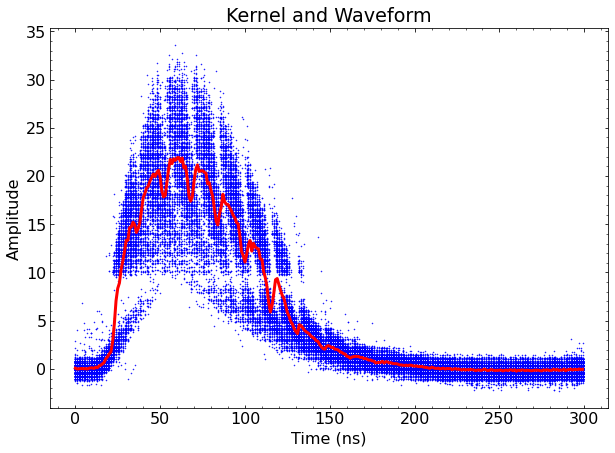

In [70]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(kernel_arr)):
    ax.plot([i for j in range(len(kernel_arr[i])-1)], kernel_arr[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
    ax.set_title("Kernel and Waveform")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
ax.plot(kernel_wf, color="red")
plt.show()

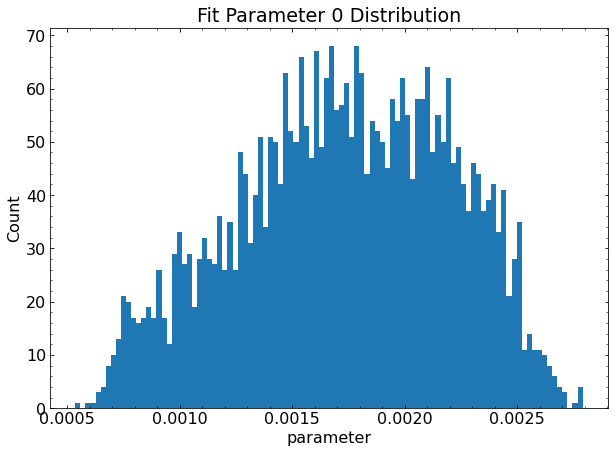

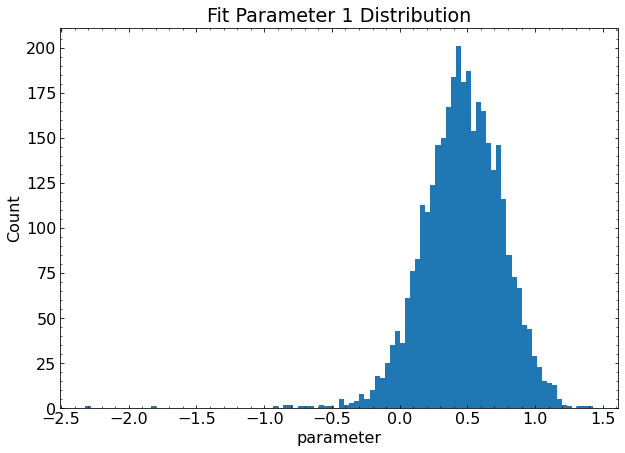

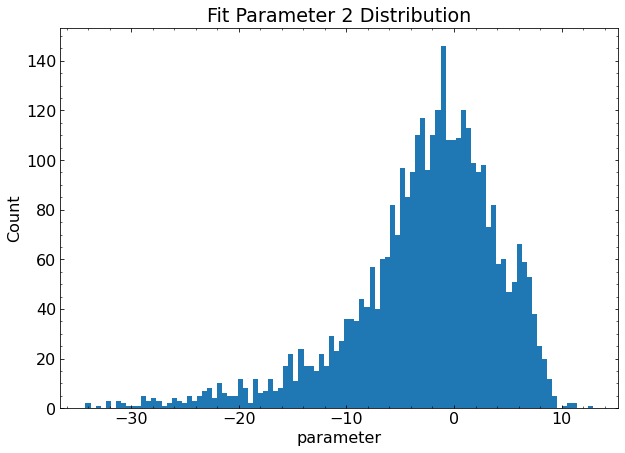

In [71]:
for j in range(3):
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist([i[0][j] for i in SPE_MCKfit], bins=100)
    ax.set_title(f"Fit Parameter {j} Distribution")
    ax.set_xlabel("parameter")
    ax.set_ylabel("Count")
    plt.show()

exp fit

In [72]:
# create an empty SPE kernel 2d array
# 300 bins from 0ns to 300ns, bin size 1ns

# timespan = 300

exp_kernel_arr = np.empty(shape=(300,), dtype=object)
print(exp_kernel_arr[119])

None


In [73]:
# time correct and normalize the selected SPEs, then place them into their corresponding bins
# Doing all three steps in the same loop because all the varaibles are ready

# starting point: SPE_expfit[j][2]


for i in range(len(SPE_expfit)):
    #norm_cst = quad(exp_func, 0, 300, args=(SPE_expfit[i][0][0],SPE_expfit[i][0][1],SPE_expfit[i][0][2]))
    #norm_cst = sum(SPE_clean[i][0:20])
    #norm_cst = max(SPE_clean[i][7:32])
    norm_cst = 1
    for j in range(len(SPE_clean[i])):
        n = int(round((j-SPE_expfit[i][2]-SPE_expfit[i][0][0])*15.625)+100)
        #n = int((j--SPE_expfit[i][2]-SPE_expfit[i][0][0])*15.625)+100
        if 0<n<300:
            exp_kernel_arr[n-1] = np.append(exp_kernel_arr[n-1], SPE_clean[i][j]/norm_cst)
        else:
            pass

# Quick formatting fix

exp_kernel_arr = exp_kernel_arr[1:-1]

In [74]:
print(exp_kernel_arr)

[array([None, 0.14285714285714285, 0.14285714285714285,
        -0.1428571428571428, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857,
        1.0, -0.14285714285714285, 0.4285714285714286, 0.14285714285714285,
        -0.14285714285714285, -1.5714285714285714, 0.14285714285714285,
        0.4285714285714286, -0.42857142857142855, -0.42857142857142855,
        0.14285714285714285, -0.1428571428571428, 0.14285714285714285,
        0.14285714285714285, -0.1428571428571428, 0.0, 1.2857142857142858,
        0.1428571428571428, 0.14285714285714285, 0.2857142857142858, 0.0,
        -0.7142857142857144, 0.5714285714285714, -0.7142857142857144,
        -0.7142857142857143, 0.0, -1.0, 0.1428571428571428,
        0.1428571428571428, 0.0, -0.1428571428571428, -0.1428571428571428,
        0.1428571428571428, 0.5714285714285714, 0.0, 0.14285714285714285,
        0.7142857142857143, 0.14285714285714285, 0.14285714285714285,
        0.14285714285714285, 0.2857142857142857, 0.0, 0.2857142857142857,
       

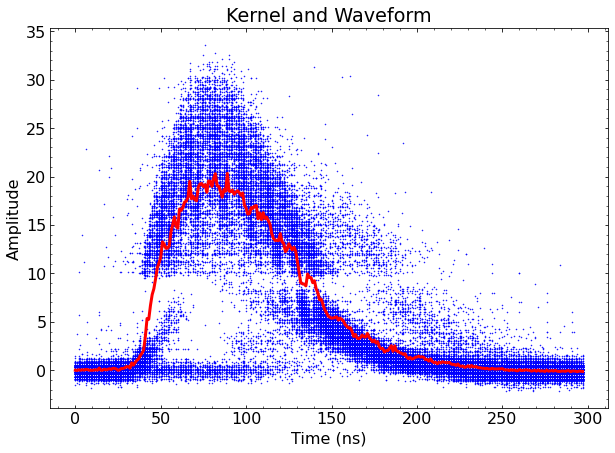

In [75]:
exp_kernel_wf = [np.mean(i[1:]) for i in exp_kernel_arr]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(exp_kernel_arr)):
    ax.plot([i for j in range(len(exp_kernel_arr[i])-1)], exp_kernel_arr[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
    ax.set_title("Kernel and Waveform")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
ax.plot(exp_kernel_wf, color="red")
plt.show()

In [76]:
# What if I increase the size of time bins?
# create an empty SPE kernel 2d array
# 300 bins from 0ns to 300ns, bin size 1ns

# timespan = 300

exp_kernel_arr = np.empty(shape=(100,), dtype=object)
print(exp_kernel_arr[0])

None


In [77]:
# time correct and normalize the selected SPEs, then place them into their corresponding bins
# Doing all three steps in the same loop because all the varaibles are ready

# starting point: SPE_expfit[j][2]


for i in range(len(SPE_expfit)):
    #norm_cst = quad(exp_func, 0, 300, args=(SPE_expfit[i][0][0],SPE_expfit[i][0][1],SPE_expfit[i][0][2]))
    #norm_cst = sum(SPE_clean[i][0:20])
    #norm_cst = max(SPE_clean[i][7:32])
    norm_cst = 1
    for j in range(len(SPE_clean[i])):
        n = int(round((round((j-SPE_expfit[i][2]-SPE_expfit[i][0][0])*15.625)+100)/3))
        #n = int((j--SPE_expfit[i][2]-SPE_expfit[i][0][0])*15.625)+100
        if 0<n<100:
            exp_kernel_arr[n-1] = np.append(exp_kernel_arr[n-1], SPE_clean[i][j]/norm_cst)
        else:
            pass

# Quick formatting fix

exp_kernel_arr = exp_kernel_arr[1:-1]

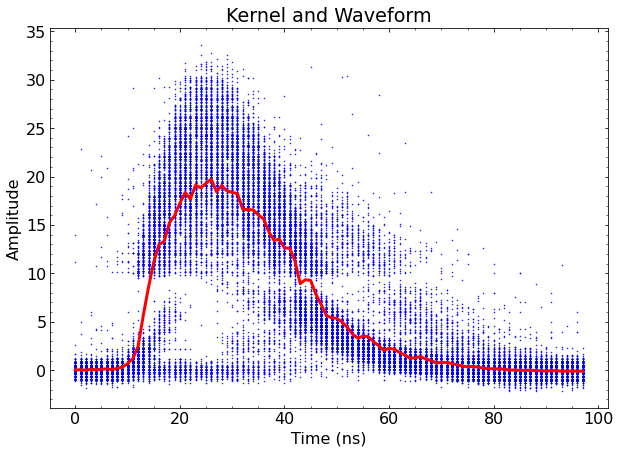

In [78]:
# this doesn't seem to work

exp_kernel_wf = [np.mean(i[1:]) for i in exp_kernel_arr]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(exp_kernel_arr)):
    ax.plot([i for j in range(len(exp_kernel_arr[i])-1)], exp_kernel_arr[i][1:], color="blue", linestyle="none", marker=".", markersize=1)
    ax.set_title("Kernel and Waveform")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
ax.plot(exp_kernel_wf, color="red")
plt.show()

For further analysis and kernel building, please see SPE_Kernel.py

### Detecting Muon signals

In [1]:
# Using similar methods as detecting SPE for detecting muons
# Assume 1 PE = 20 ADU

# Some global varaibles for checking different cuts
maxprepul = []
maxafterpul = []

def muon(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    i = 0
    while i < len(data[init:]):
        cache = []
        #if 2000>data[i]-baseline>100:
        if 1950>data[i]-baseline>100:
            if len(data[i-20:i-1])!=0 and abs(rms) <=150:
                maxprepul.append(np.max([j-baseline for j in data[i-20:i-1]]))
            else:
                pass
            if len(data[i-20:i-1])!=0 and -rms<np.max([j-baseline for j in data[i-20:i-1]])<rms and abs(rms)<=150:
                cache.extend(data[i-20:i-1])
                #while 2000>data[i]-baseline>100 and i in range(len(data[init:])):
                while 1900>data[i]-baseline>100 and i in range(len(data[init:])):
                    cache.append(data[i])
                    i += 1
                cache.extend(data[i+1:i+20])
            # end of the waveform here is defined as i+20 by observation
                maxafterpul.append(np.max(data[i+20:i+20+after]-baseline))
                # TODO: double check the afterpulse selection conditions, it might be too long
                #if np.max(data[i+20:i+20+after]-baseline) <= 10*rms and np.max(data[i:i+20]-baseline) < 2000:
                #if np.max(data[i+20:i+20+after]-baseline)/np.max(cache) <= 0.2 and np.max(data[i:i+20]-baseline) < 2000 and len(data[i+20:i+20+after])==after:
                if np.max(data[i+15:i+20+after]-baseline)/np.max(cache-baseline) <= 0.5 and np.max(data[i:i+20]-baseline) < 1900 and len(data[i+20:i+20+after])==after:
                    #print(np.max(data[i+15:i+20+after]-baseline))
                    #print(np.max(cache))
                    cache.extend(data[i+1:i+4+after])
                    #break
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0:
            waveform.append(list(cache)-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
        else:
            pass
        i += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

In [2]:
# Acquiring raw muon waveforms

muon_arr = np.empty(6, dtype=object)

for i in range(len(wfdf["wf_26"][0:10000])):
    m_temp = [muon(wfdf["wf_26"][i],baseline_arr[i,0],baseline_arr[i,1],init_time,200)]
    if m_temp[0] != "N":
        for j in range(len(m_temp)):
            for l in range(len(m_temp[j][0])):
                muon_arr = np.vstack((muon_arr, np.asarray([m_temp[j][k][l] for k in range(len(m_temp[j]))])))
    else:
        pass

muon_arr = muon_arr[1:]

#print(f"Stage 1: {} waveforms")
#print(f"Stage 2: {} waveforms")

NameError: name 'np' is not defined

In [ ]:
# Histograms of the relevant parameter distributions and the cuts I made

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
#ax.hist(bslin_good[:,0], bins=np.linspace(0,50,100))
ax.hist(baseline_arr[:,1], bins=100)
ax.hist(muon_arr[:, 5], bins=14)
ax.set_title("Good Baseline Evts RMS Distribution")
plt.show()

In [ ]:
# Amplitude distribution

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(muon_arr[:,1], bins=500)
ax.set_title("Amplitude Distribution")
#ax.set_xlim(0, 250)
ax.minorticks_on()
plt.show()

In [ ]:
# TODO: generate avg prepulse & afterpulse data for each wf

# Distribution of prepulse

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(maxprepul, bins=500)
ax.set_title("Prepulse Amplitude Distribution")
plt.show()

In [ ]:
# Distribution of afterpulse

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(maxafterpul, bins=100)
ax.set_title("Afterpulse Amplitude Distribution")
plt.show()

In [ ]:
# Overlaying all the waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(muon_arr)):
    ax.plot(muon_arr[i][0], color="peru", linewidth=0.5)
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
ax.set_xlim(0,200)
plt.show()

print(f"Amount of Muon waveforms selected {len(muon_arr)}")

In [ ]:
# TODO: Re-adjust the waveform baselines
# Consider aligning prepulse vs using median

for i in range(len(muon_arr)):
    muon_arr[i][0] = muon_arr[i][0]-min(muon_arr[i][0][:15])
    #muon_arr[i][0] = muon_arr[i][0]-np.median(muon_arr[i][0])

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(muon_arr)):
    ax.plot(muon_arr[i][0], color="peru", linewidth=0.5)
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
ax.set_xlim(0,200)
plt.show()

print(f"Amount of Muon waveforms selected {len(muon_arr)}")

In [ ]:
# Sum all waveforms, produce a rough response function
# Since the length of the kernel is 200 ticks, the response function length will also be 200 ticks

res_fun = np.zeros(shape=(200,), dtype=object)

fig, ax = plt.subplots(figsize =(10, 7))
#fig, ax = plt.subplots(figsize =(5, 7))
for i in muon_arr:
    for j in range(200):
        res_fun[j] += i[0][j]
ax.plot(res_fun)
ax.set_title("Sum of Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.yscale("log")
#ax.set_ylim(-5000, 80000)
#ax.set_xlim(0,50)
plt.show()

In [45]:
# Export selected muon waveforms

%store muon_arr res_fun

Stored 'muon_arr' (ndarray)
Stored 'res_fun' (ndarray)


### Empty Background Selection

To improve the quality of the Muon signals, I will sample instances without muon signals and develop a background response function that can be deducted from the muon response function.

In [46]:
# Notes on ideas:
# DO NOT go through waveform selection process, simply sample a bunch of 192 time tick segments without muon randomly
# In addition to checking there's no muons, also only take the initial time span (to ensure randomness)

def nomuon(data, baseline, rms, init, wlen):
    waveform = []
    if abs(rms)<=50 and 45>max(data[0:wlen]-baseline)>-45 and min(data[0:wlen]-baseline)>(-rms) and len(data[0:wlen])==wlen:
        waveform = data[0:0+wlen]-baseline
        return waveform
    else:
        return waveform

In [59]:
# Acquiring empty backgrounds
# The time window of backgrounds will still be 192 ticks (3000ns) for now

# This turns out to be searching completely quiet evts, since evt time spans are always 1500 ticks

nomuon_arr = []

for i in range(len(wfdf["wf_26"][0:10000])):
    nomuon_cache = nomuon(wfdf["wf_26"][i],baseline_arr[i,0],baseline_arr[i,1],init_time,1500)
    if len(nomuon_cache) != 0:
        nomuon_arr.append(nomuon_cache)
    else:
        pass

nomuon_arr = np.array(nomuon_arr)

KeyboardInterrupt: 

In [ ]:
# Re-adjust the waveform baseline

for i in range(len(nomuon_arr)):
    nomuon_arr[i] = nomuon_arr[i]-np.median(nomuon_arr[i])

In [ ]:
# Overlay all the selected waveforms
# Why do the signals generally increase at the end?
# Idea: add some selection area padding
# What will happen with different cuts?

fig, ax = plt.subplots(figsize =(20, 7))
for i in nomuon_arr:
    ax.plot(i, color="peru", linewidth=0.5)
ax.set_title("Background Signal")
#plt.yscale("log")
#ax.set_ylim(-10, 40)
#ax.set_xlim(175,200)
plt.show()

In [ ]:
# Check out some distributions

# Amplitude distribution
nomuon_amp = [i[np.where(abs(i)==max(abs(i)))[0][0]] for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_amp, bins=100)
ax.set_title("Background Signal Amplitude Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

# Area Distribution
nomuon_area = [sum(i) for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_area, bins=100)
ax.set_title("Background Signal Area Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

In [ ]:
# Generate response function

# TODO: Consider not including bkg subtraction in presentation
# Observation: the first 400 ticks may not be useful
# Does this discredit the baseline calculation?
# There's no muons in the 1500 ticks, but after that there's muons in every evts, does this have sth to do with triggering?

nomuon_res = [sum([nomuon_arr[j][i] for j in range(len(nomuon_arr))]) for i in range(len(nomuon_arr[0]))]

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(nomuon_res)
ax.set_title("Background Signal Raw Response Function")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

In [60]:
# Alternative method: Do a generalized search across all avaliable time, excluding the first 500 ticks.
# Problem with choosing background in all timespan: some weird instances of some baseline fluctuation patterns, 
# signals with not good enough baselines, etc

def nomuon(data, baseline, rms, init, wlen):
    waveform = []
    i = init
    if abs(rms)<=50:
        while i < len(data[init:1500]):
            # Give some extra padding at both ends
            m = max(data[i+init-20:i+init+wlen+20])-baseline
            n = min(data[i+init-20:i+init+wlen+20])-baseline
            if len(data[i+init:i+init+wlen])==wlen and 45>m>(-45) and 45>n>(-45) and (m-n)<90:
                waveform.append(data[i+init:i+init+wlen]-baseline)
                i += wlen
            else:
                i += 1
    else:
        pass
    return waveform

In [61]:
# Acquiring empty backgrounds
# The time window of backgrounds will 200 ticks

nomuon_arr = []

for i in range(len(wfdf["wf_26"][0:10000])):
    nomuon_cache = nomuon(wfdf["wf_26"][i],baseline_arr[i,0],baseline_arr[i,1],600,200)
    if len(nomuon_cache) != 0:
        for i in range(len(nomuon_cache)):
            nomuon_arr.append(nomuon_cache[i])
    else:
        pass

nomuon_arr = np.array(nomuon_arr)

In [62]:
# Re-adjust the waveform baseline

for i in range(len(nomuon_arr)):
    nomuon_arr[i] = nomuon_arr[i]-np.median(nomuon_arr[i])

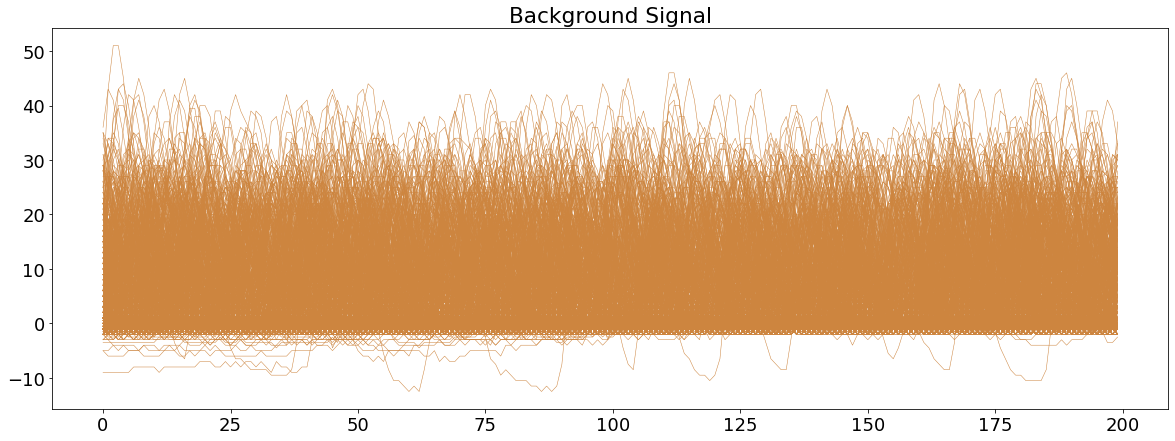

In [63]:
# Overlay all the selected waveforms
# Why do the signals generally increase at the end?
# Idea: add some selection area padding
# What will happen with different cuts?

fig, ax = plt.subplots(figsize =(20, 7))
for i in nomuon_arr:
    ax.plot(i, color="peru", linewidth=0.5)
ax.set_title("Background Signal")
#plt.yscale("log")
#ax.set_ylim(-10, 40)
#ax.set_xlim(175,200)
plt.show()

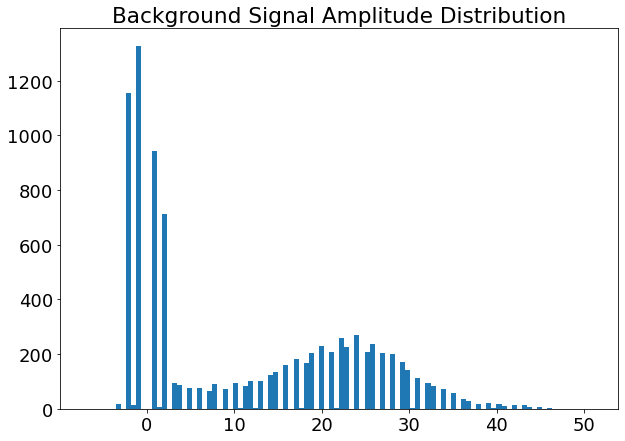

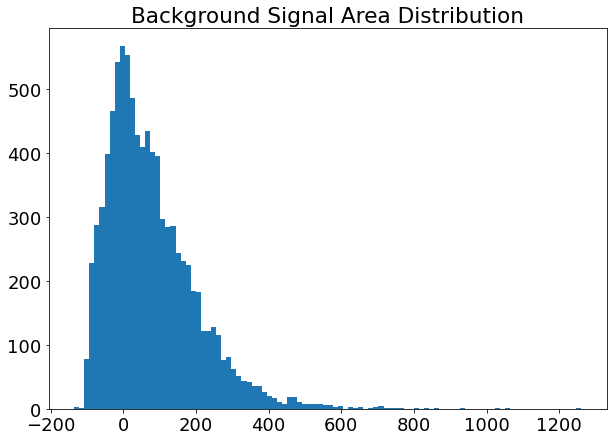

In [64]:
# Check out some distributions

# Amplitude distribution
nomuon_amp = [i[np.where(abs(i)==max(abs(i)))[0][0]] for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_amp, bins=100)
ax.set_title("Background Signal Amplitude Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

# Area Distribution
nomuon_area = [sum(i) for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_area, bins=100)
ax.set_title("Background Signal Area Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

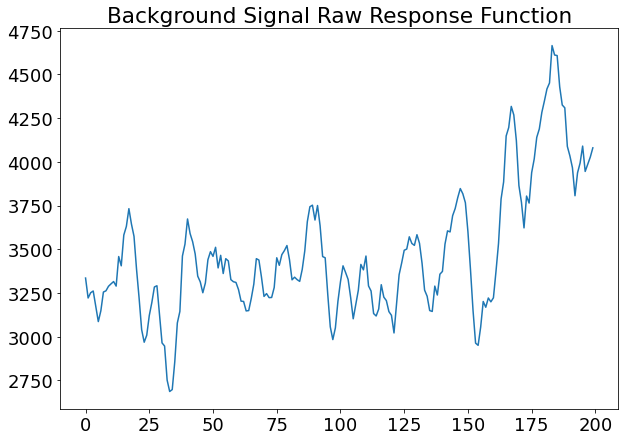

In [65]:
# Generate response function

# TODO: Consider not including bkg subtraction in presentation
# Observation: the first 400 ticks may not be useful
# Does this discredit the baseline calculation?
# There's no muons in the 1500 ticks, but after that there's muons in every evts, does this have sth to do with triggering?

nomuon_res = [sum([nomuon_arr[j][i] for j in range(len(nomuon_arr))]) for i in range(len(nomuon_arr[0]))]

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(nomuon_res)
ax.set_title("Background Signal Raw Response Function")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

In [66]:
%store nomuon_arr nomuon_res

Stored 'nomuon_arr' (ndarray)
Stored 'nomuon_res' (list)
